# Sacrifice Fly Analysis

## Prerequisites

### On Base Data
1. Expected dataset filenames:
    - `/data/throw_home_runner_on_first.parquet`
    - `/data/throw_home_runner_on_second.parquet`
    - `/data/throw_home_runner_on_third.parquet`
2. All datasets include column names from [column names](../data/on_base_column_names.txt)

### Download Top Average Arm Strength

1. Download arm strength csv by year.
    - https://baseballsavant.mlb.com/leaderboard/arm-strength?type=player&year=2020&minThrows=50&pos=&team=
    - https://baseballsavant.mlb.com/leaderboard/arm-strength?type=player&year=2021&minThrows=50&pos=&team=
    - https://baseballsavant.mlb.com/leaderboard/arm-strength?type=player&year=2022&minThrows=50&pos=&team=
    - https://baseballsavant.mlb.com/leaderboard/arm-strength?type=player&year=2023&minThrows=50&pos=&team=
    - https://baseballsavant.mlb.com/leaderboard/arm-strength?type=player&year=2024&minThrows=50&pos=&team=
    - https://baseballsavant.mlb.com/leaderboard/arm-strength?type=player&year=2025&minThrows=50&pos=&team=
2. Rename the files to "arm_strength_<year>.csv" e.g. "arm_strength_2020.csv". An improvement would be to scrape the data from Google StatCast or create an equivalent dataset in-house.

### Environment Dependencies

1. Install `uv` python package manager
2. Install and pin a python with version greater than 3.11
3. Run `uv sync` to install project, python dependencies 
4. In the home project directory, run `uv pip install -e .` to install the source packages.

In [2]:
# Install packages from `src`
! uv pip install -e ..
# Sync packages
! uv sync

Using Python 3.11.11 environment at: /home/taylorswrite/git/Sacrifice-Fly-Modeling/.venv
Resolved 87 packages in 198ms                                        
   Building sacrifice-fly-modeling @ file:///home/taylorswrite/git/Sacrifice-Fly-Mod
   Building sacrifice-fly-modeling @ file:///home/taylorswrite/git/Sacrifice-Fly-Mod
      Built sacrifice-fly-modeling @ file:///home/taylorswrite/git/Sacrifice-Fly-Mod
Prepared 1 package in 395ms                                              
Uninstalled 1 package in 0.37ms
Installed 1 package in 0.53ms==0.1.0 (from file:///home/tayl
 ~ sacrifice-fly-modeling==0.1.0 (from file:///home/taylorswrite/git/Sacrifice-Fly-Modeling)
Resolved 100 packages in 7ms
Audited 97 packages in 0.07ms


## Prepare the Data

In [3]:
! uv run ../run/data_prep/data_prep_run.py

Processing runner on third data at: /home/taylorswrite/git/Sacrifice-Fly-Modeling/data/throw_home_runner_on_third.parquet
Widened runner on third by fielder features
Filtered runner on third data for plays with less than one out
Merged Sprint data for runner on third by fielder features
Merged arm strength data for runner on third by fielder features
Created Target Feature Successful Sac Fly
Saved data to: /home/taylorswrite/git/Sacrifice-Fly-Modeling/data
Processing runner on second data at: /home/taylorswrite/git/Sacrifice-Fly-Modeling/data/throw_home_runner_on_second.parquet
Widened runner on second by fielder features
Filtered runner on second data for plays with less than one out
Merged Sprint data for runner on second by fielder features
Merged arm strength data for runner on second by fielder features
Created Target Feature Successful Sac Fly
Saved data to: /home/taylorswrite/git/Sacrifice-Fly-Modeling/data


## Importing Project Dependencies

In [4]:
import os
import random
import polars as pl
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from pybaseball import statcast, spraychart
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score
from models import model_prep_on_base, create_model_pipeline
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib.lines import Line2D
from scipy.stats import norm

random.seed(123)

In [5]:
on_base_path = os.path.abspath("../data/throw_home_runner_on_third_wide_sprint_arm.parquet")
on_base_lf = pl.scan_parquet(on_base_path)

## Game State Filtering

### Unfiltered Data

In [6]:

statcast_pd = statcast(start_dt="2023-04-01", 
                       end_dt="2023-10-01",
                       team = "LAD",
                       verbose = False
)

/home/taylorswrite/git/Sacrifice-Fly-Modeling/.venv/lib/python3.11/site-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
  1%|          | 1/184 [00:00<01:56,  1.57it/s]/home/taylorswrite/git/Sacrifice-Fly-Modeling/.venv/lib/python3.11/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime with

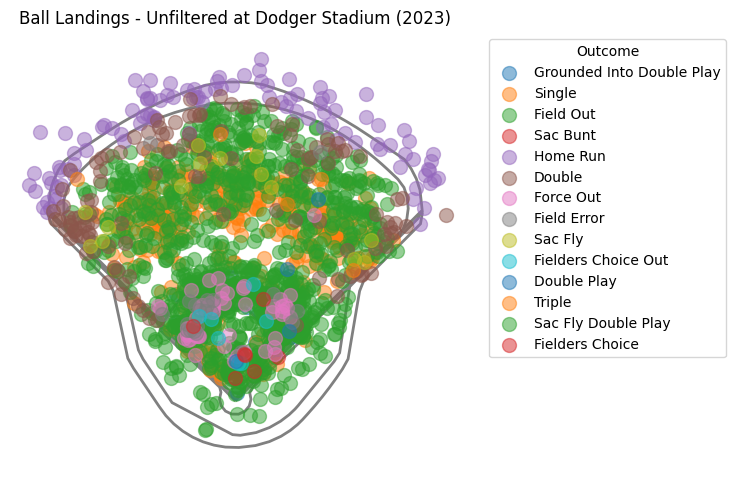

<Axes: title={'center': 'Ball Landings - Unfiltered at Dodger Stadium (2023)'}>

In [7]:
statcast_pd['hc_x'] = pd.to_numeric(statcast_pd['hc_x'], errors='coerce')
statcast_pd['hc_y'] = pd.to_numeric(statcast_pd['hc_y'], errors='coerce')
statcast_pd = statcast_pd.dropna(subset=['hc_x', 'hc_y'])
statcast_pd = statcast_pd[statcast_pd['home_team'] == 'LAD']

spraychart(statcast_pd, 'dodgers', title='Ball Landings - Unfiltered at Dodger Stadium (2023)')

### Filtered for Balls Caught by the Outfield

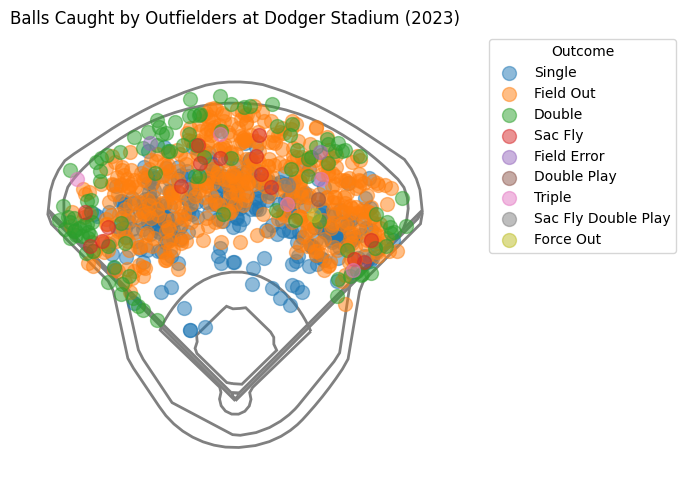

<Axes: title={'center': 'Balls Caught by Outfielders at Dodger Stadium (2023)'}>

In [8]:
outfielder_caught_pd = statcast_pd[statcast_pd['hit_location'].isin([7.0, 8.0, 9.0])].copy()

spraychart(outfielder_caught_pd, 'dodgers', title='Balls Caught by Outfielders at Dodger Stadium (2023)')

### Outcomes related to the Sac Fly

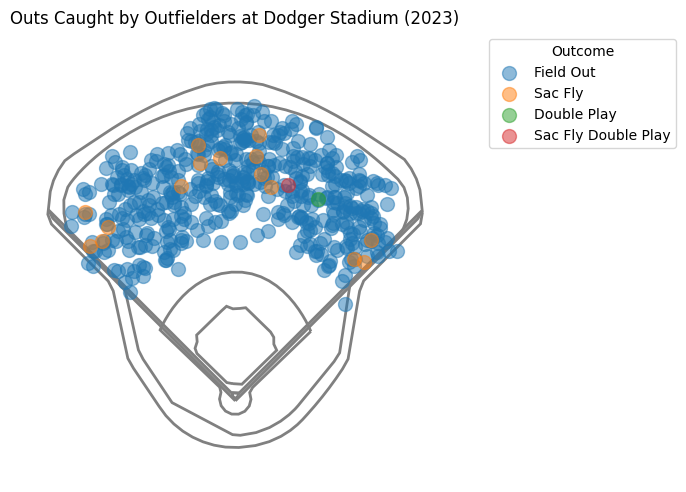

<Axes: title={'center': 'Outs Caught by Outfielders at Dodger Stadium (2023)'}>

In [9]:
outcomes = ['field_out', 'sac_fly', 'double_play', 'sac_fly_double_play']
outcomes_pd = outfielder_caught_pd[(outfielder_caught_pd['events'].isin(outcomes))].copy()

spraychart(outcomes_pd, 'dodgers', title='Outs Caught by Outfielders at Dodger Stadium (2023)')

### Game States Where a Sac Fly Would be Attempted

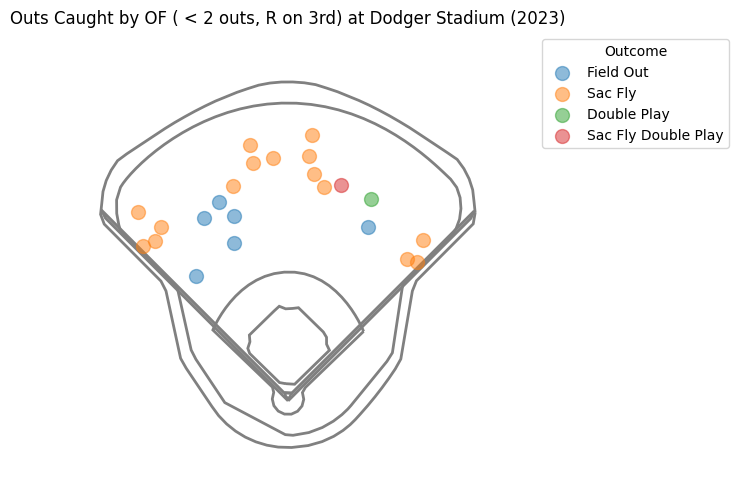

<Axes: title={'center': 'Outs Caught by OF ( < 2 outs, R on 3rd) at Dodger Stadium (2023)'}>

In [10]:
gamestate_pd = outcomes_pd[(outcomes_pd['outs_when_up'] < 2) & (outcomes_pd['on_3b'].notnull())].copy()

spraychart(gamestate_pd, 'dodgers', title='Outs Caught by OF ( < 2 outs, R on 3rd) at Dodger Stadium (2023)')

## EDA - Runner on Third

### Play Outcome Frequencies


**Definitions**
- Successful when `event_type` was a `sac_fly` or `sac_fly_double_play`
- Unsuccessful when `event_type` was a `field_out` or `double_play`

**Takeaway**
- Successful Sacrifice Fly is the majority case.

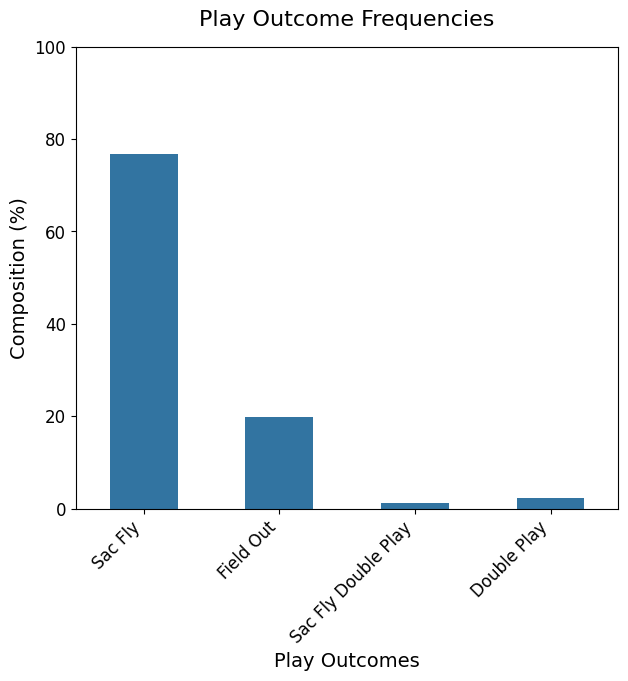

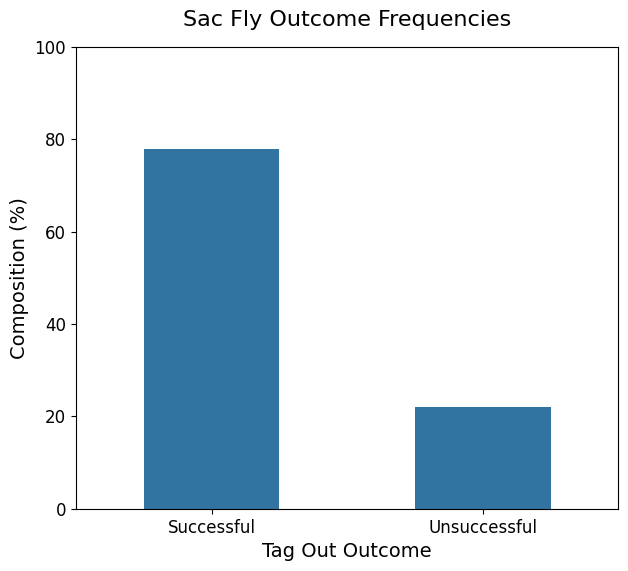

In [11]:
event_dict = {
    "sac_fly": "Sac Fly",
    "sac_fly_double_play": "Sac Fly Double Play",
    "field_out": "Field Out",
    "double_play": "Double Play"
}

successful_lf = (on_base_lf
    .select(["event_type"])
    .with_columns(
        pl.when(pl.col("event_type").is_in(["sac_fly", "sac_fly_double_play"]))
          .then(pl.lit("Successful"))
          .otherwise(pl.lit("Unsuccessful"))
          .alias("is_successful"),
        pl.col("event_type").replace(event_dict).alias("event_type")
    )
)

successful_pd = successful_lf.collect().to_pandas()

plt.figure(figsize=(7, 6))
sns.countplot(x="event_type", stat="percent", data=successful_pd, width=.5)
plt.title("Play Outcome Frequencies", fontsize=16, pad=15)
plt.ylim(0, 100)
plt.xticks(fontsize=12, rotation=45, ha='right')  # Add ha='right'
plt.yticks(fontsize=12)
plt.xlabel("Play Outcomes", fontsize=14)
plt.ylabel("Composition (%)", fontsize=14)
plt.show()

plt.figure(figsize=(7, 6))
sns.countplot(x="is_successful", stat = "percent", data=successful_pd, width = .5)
plt.title("Sac Fly Outcome Frequencies", fontsize=16, pad=15)
plt.ylim(0, 100)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Tag Out Outcome", fontsize=14)
plt.ylabel("Composition (%)", fontsize=14)
plt.show()

### Sprint Speed - Data Leak

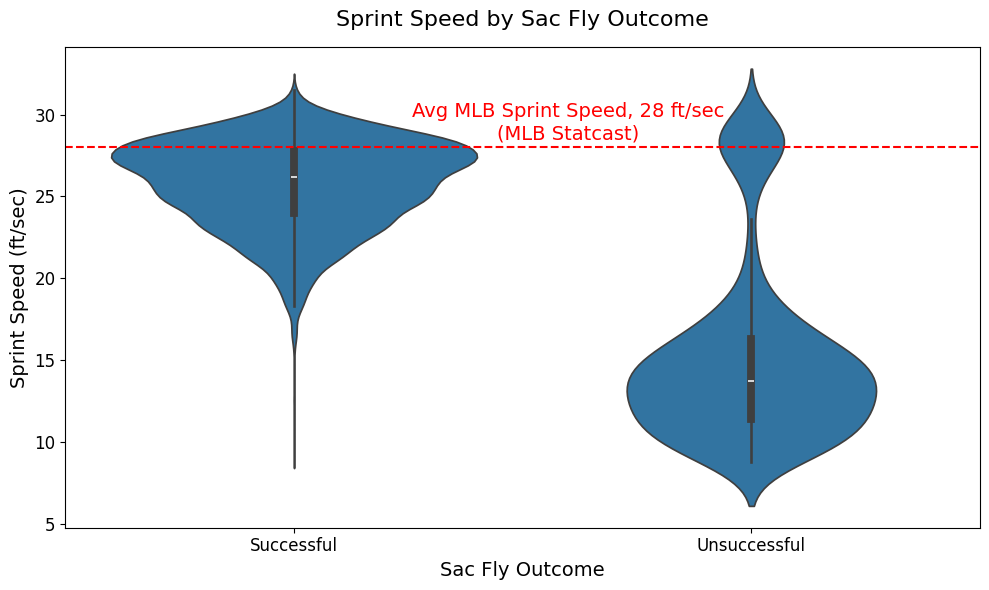

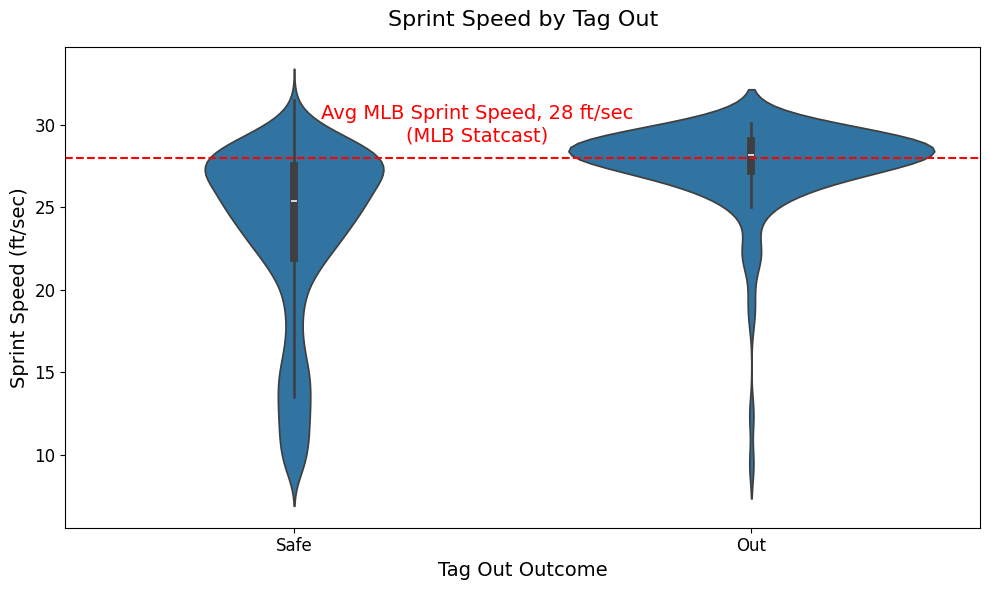

In [12]:
successful_dict = {
    "true": "Successful",
    "false": "Unsuccessful"
}

sprint_pd = (on_base_lf
    .select(["sprint_speed_runner", "seconds_since_hit_085_mlb_person_id_R3", "is_successful", "is_out"])
    .with_columns(
        pl.when(pl.col("is_out") == True)
          .then(pl.lit("Out"))
          .otherwise(pl.lit("Safe"))
          .alias("is_out"),
        pl.col("is_successful").cast(pl.String).replace(successful_dict)
    )
    .collect()
    .to_pandas()
)

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x= "is_successful", y='sprint_speed_runner', data=sprint_pd)

# Add a line at 28 ft/sec
plt.axhline(y=28, color='red', linestyle='--', label='28 ft/sec')
plt.gca().text(0.6, 28.5, 'Avg MLB Sprint Speed, 28 ft/sec\n(MLB Statcast)', color='red', fontsize=14, ha='center')

# Formatting the plot
plt.title("Sprint Speed by Sac Fly Outcome", fontsize=16, pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Sac Fly Outcome", fontsize=14)
plt.ylabel("Sprint Speed (ft/sec)", fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x= "is_out", y='sprint_speed_runner', data=sprint_pd, order=["Safe", "Out"])

# Add a line at 28 ft/sec
plt.axhline(y=28, color='red', linestyle='--', label='28 ft/sec')
plt.gca().text(0.4, 29, 'Avg MLB Sprint Speed, 28 ft/sec\n(MLB Statcast)', color='red', fontsize=14, ha='center')

# Formatting the plot
plt.title("Sprint Speed by Tag Out", fontsize=16, pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Tag Out Outcome", fontsize=14)
plt.ylabel("Sprint Speed (ft/sec)", fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

### 85ft Sprint Split - Sprint Leak Solution

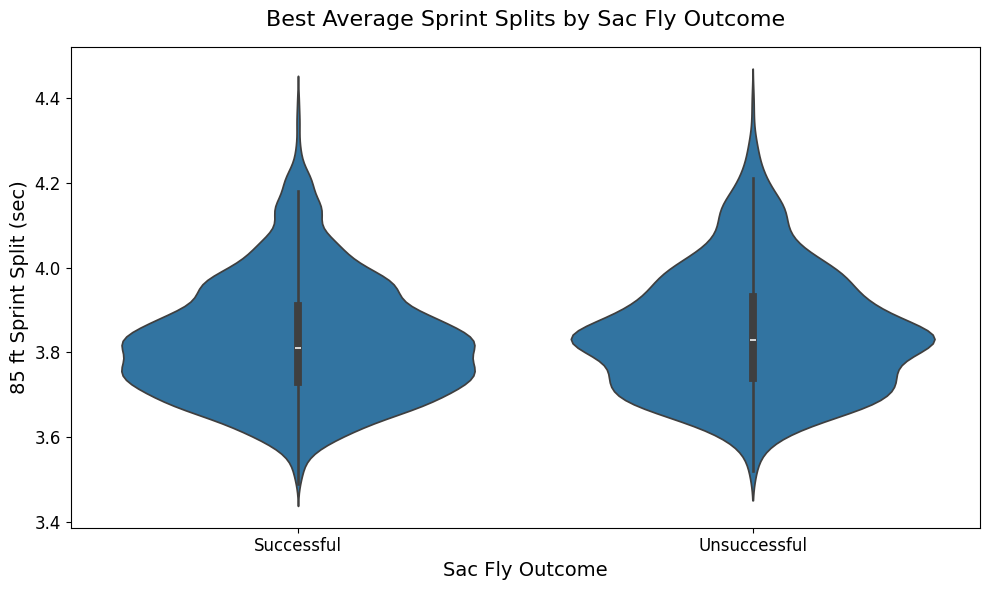

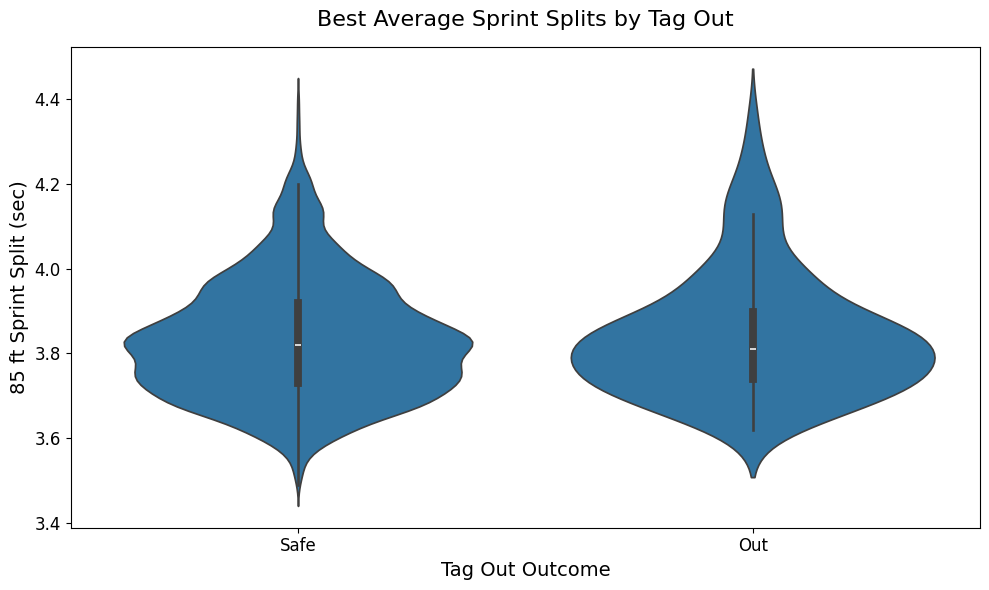

In [13]:
# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x= "is_successful", y='seconds_since_hit_085_mlb_person_id_R3', data=sprint_pd)

# Formatting the plot
plt.title("Best Average Sprint Splits by Sac Fly Outcome", fontsize=16, pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Sac Fly Outcome", fontsize=14)
plt.ylabel("85 ft Sprint Split (sec)", fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x= "is_out", y='seconds_since_hit_085_mlb_person_id_R3', data=sprint_pd, order=["Safe", "Out"])

# Formatting the plot
plt.title("Best Average Sprint Splits by Tag Out", fontsize=16, pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Tag Out Outcome", fontsize=14)
plt.ylabel("85 ft Sprint Split (sec)", fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

### Arm Strength - Data Leak

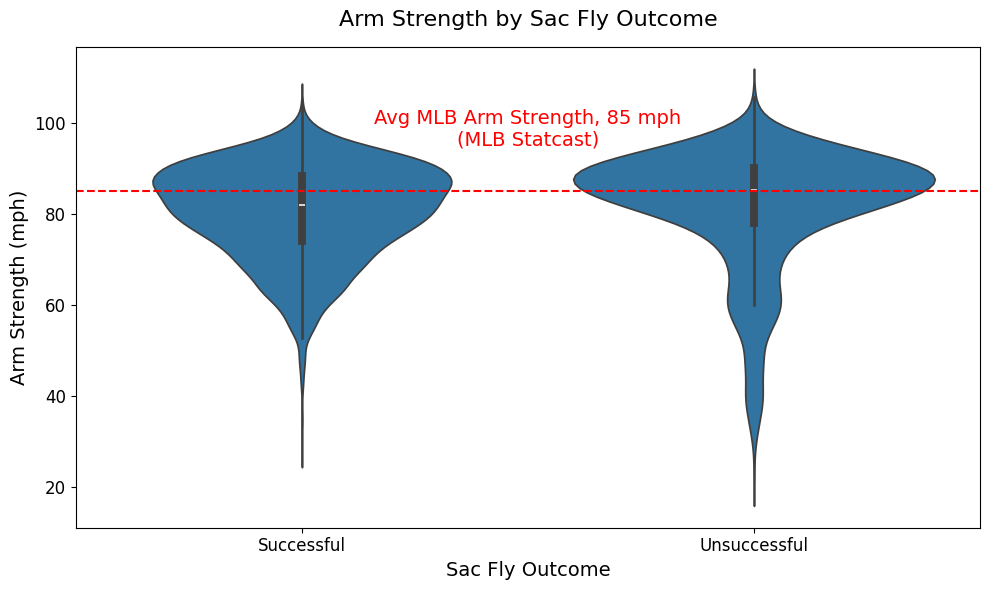

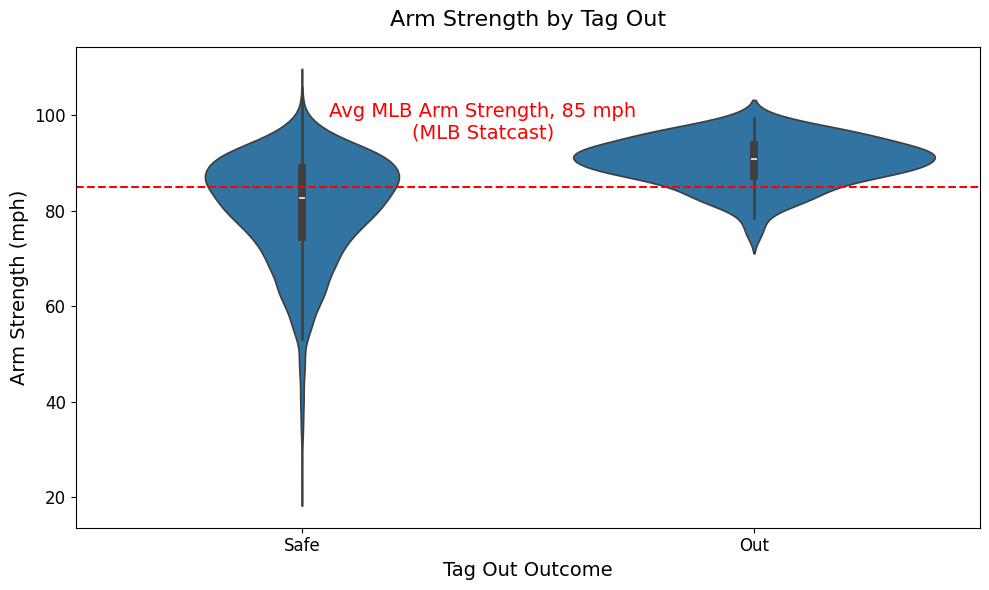

In [14]:
successful_dict = {
    "true": "Successful",
    "false": "Unsuccessful"
}

arm_strength_pd = (on_base_lf
    .select(["arm_strength", "arm_overall_fielder_mlb_person_id", "is_successful", "is_out"])
    .with_columns(
        pl.when(pl.col("is_out") == True)
          .then(pl.lit("Out"))
          .otherwise(pl.lit("Safe"))
          .alias("is_out"),
        pl.col("is_successful").cast(pl.String).replace(successful_dict)
    )
    .collect()
    .to_pandas()
)

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x= "is_successful", y='arm_strength', data=arm_strength_pd)

# Add a line at 85ft
plt.axhline(y=85, color='red', linestyle='--', label='85 ft/sec')
plt.gca().text(0.5, 95, 'Avg MLB Arm Strength, 85 mph\n(MLB Statcast)', color='red', fontsize=14, ha='center')

# Formatting the plot
plt.title("Arm Strength by Sac Fly Outcome", fontsize=16, pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Sac Fly Outcome", fontsize=14)
plt.ylabel("Arm Strength (mph)", fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x= "is_out", y='arm_strength', data=arm_strength_pd, order=["Safe", "Out"])

# Add a line at 85ft
plt.axhline(y=85, color='red', linestyle='--', label='85 ft/sec')
plt.gca().text(0.4, 95, 'Avg MLB Arm Strength, 85 mph\n(MLB Statcast)', color='red', fontsize=14, ha='center')

# Formatting the plot
plt.title("Arm Strength by Tag Out", fontsize=16, pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Tag Out Outcome", fontsize=14)
plt.ylabel("Arm Strength (mph)", fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

### Top Average Arm Strengths - Data Leak Solution

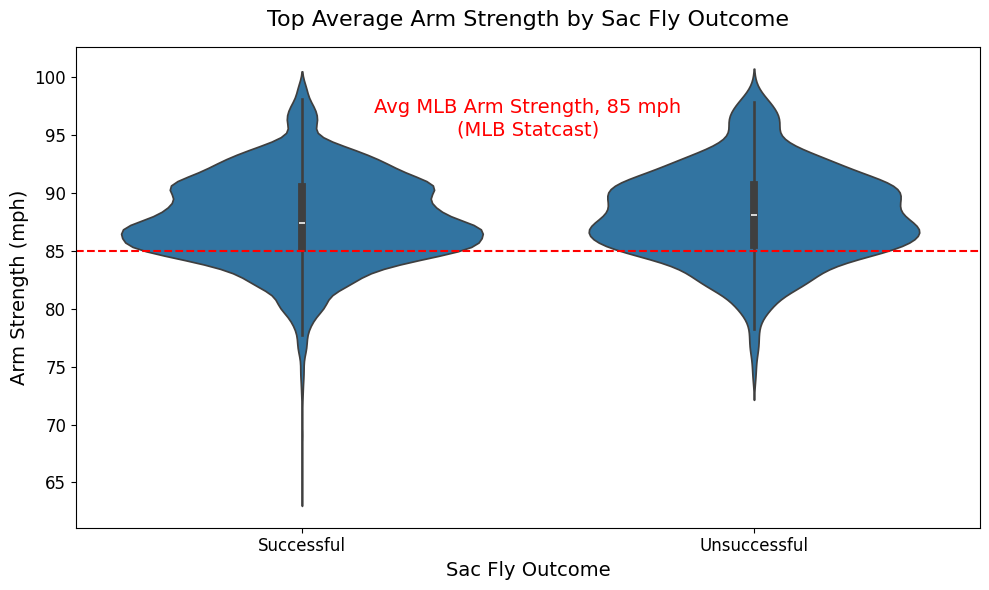

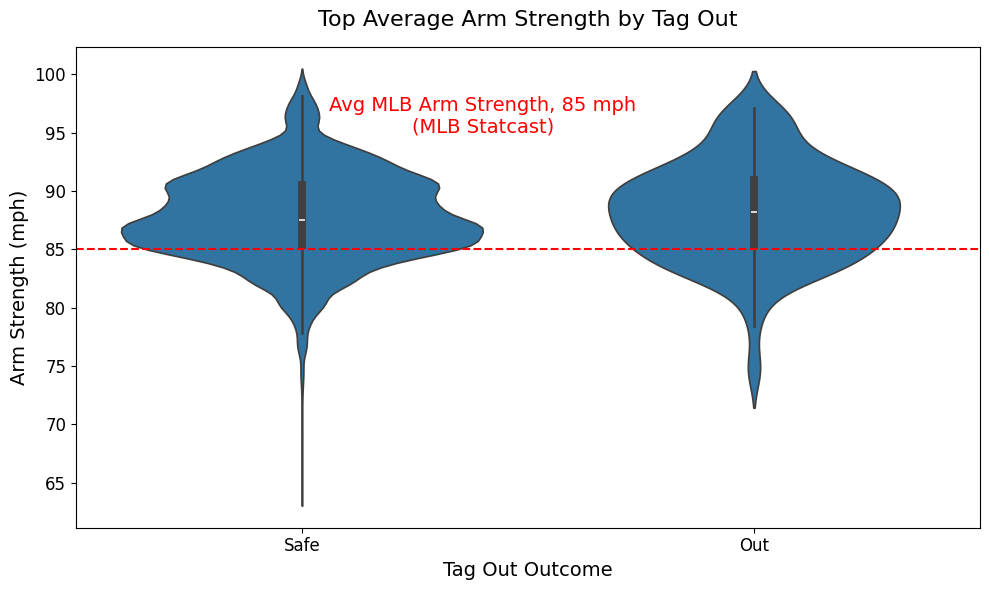

In [15]:
# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x= "is_successful", y='arm_overall_fielder_mlb_person_id', data=arm_strength_pd)

# Add a line at 85ft
plt.axhline(y=85, color='red', linestyle='--', label='85 ft/sec')
plt.gca().text(0.5, 95, 'Avg MLB Arm Strength, 85 mph\n(MLB Statcast)', color='red', fontsize=14, ha='center')

# Formatting the plot
plt.title("Top Average Arm Strength by Sac Fly Outcome", fontsize=16, pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Sac Fly Outcome", fontsize=14)
plt.ylabel("Arm Strength (mph)", fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x= "is_out", y='arm_overall_fielder_mlb_person_id', data=arm_strength_pd, order=["Safe", "Out"])

# Add a line at 85ft
plt.axhline(y=85, color='red', linestyle='--', label='85 ft/sec')
plt.gca().text(0.4, 95, 'Avg MLB Arm Strength, 85 mph\n(MLB Statcast)', color='red', fontsize=14, ha='center')

# Formatting the plot
plt.title("Top Average Arm Strength by Tag Out", fontsize=16, pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Tag Out Outcome", fontsize=14)
plt.ylabel("Arm Strength (mph)", fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

## Feature Engineering

### Catch Distance to Home and Each Base

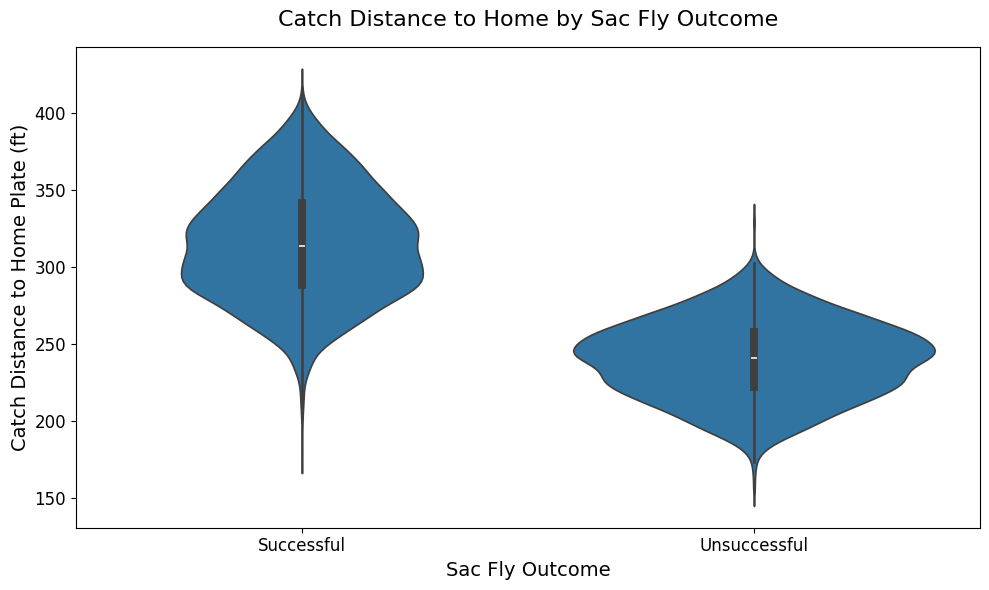

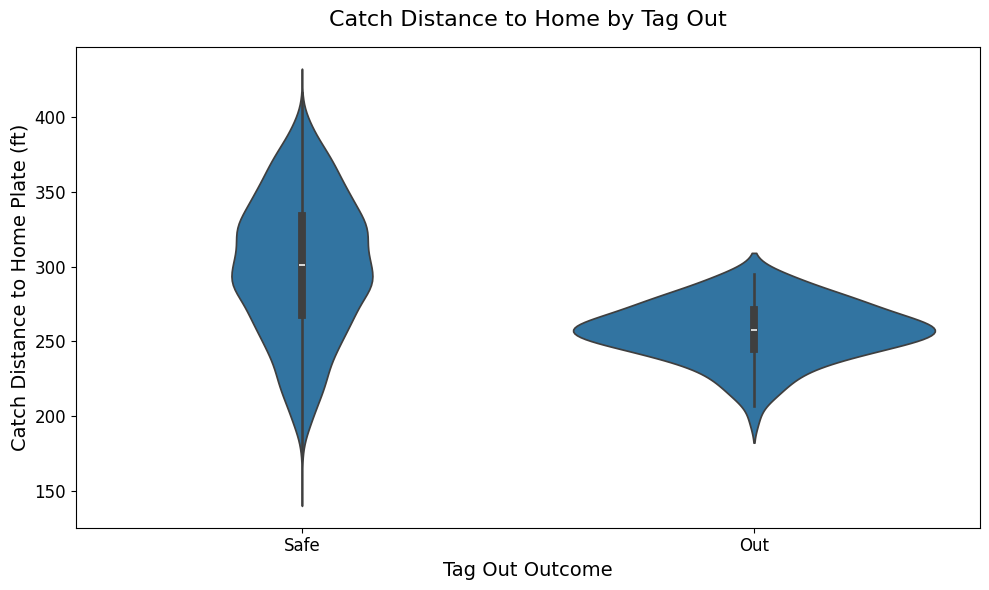

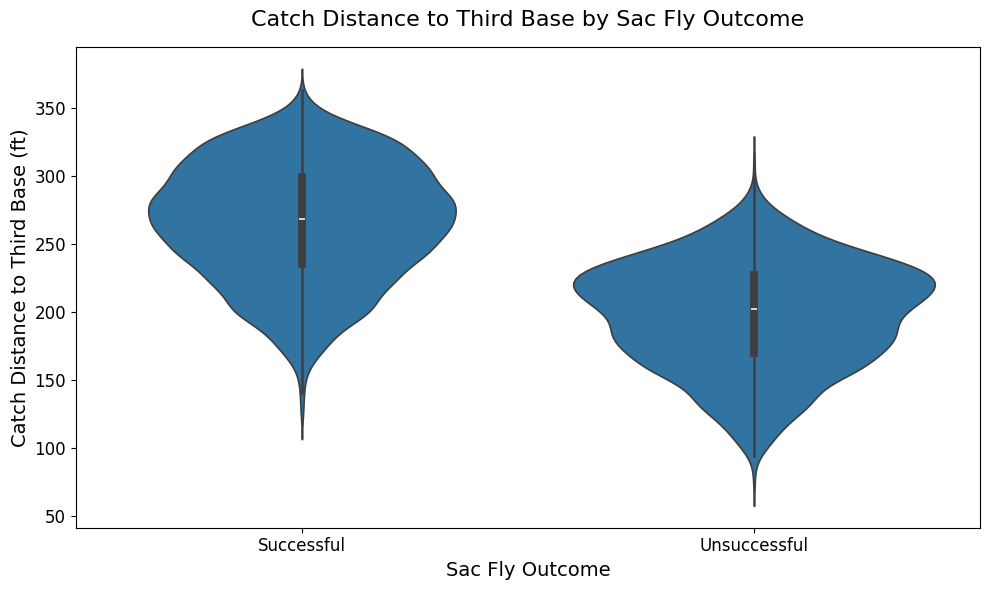

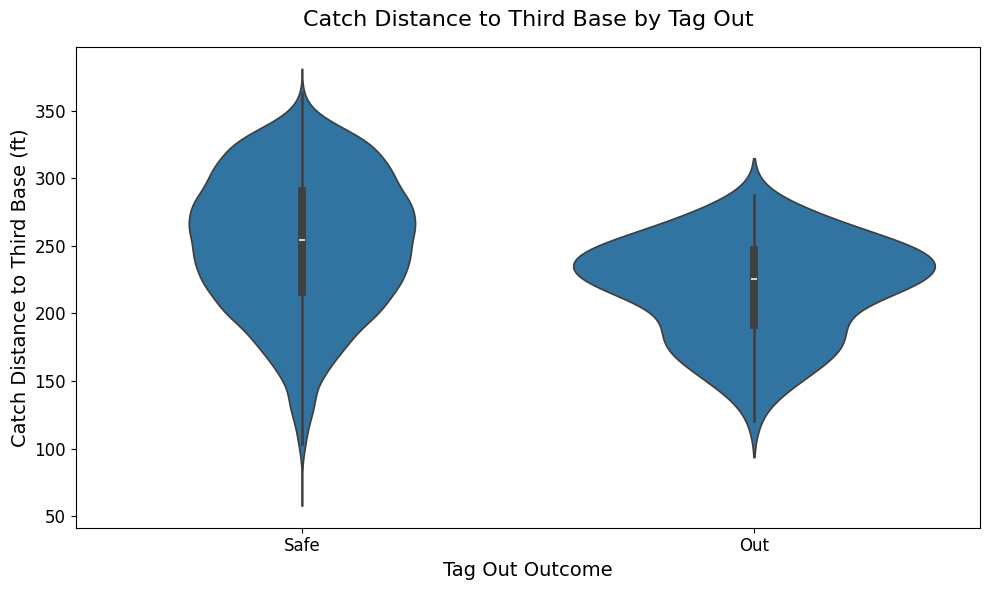

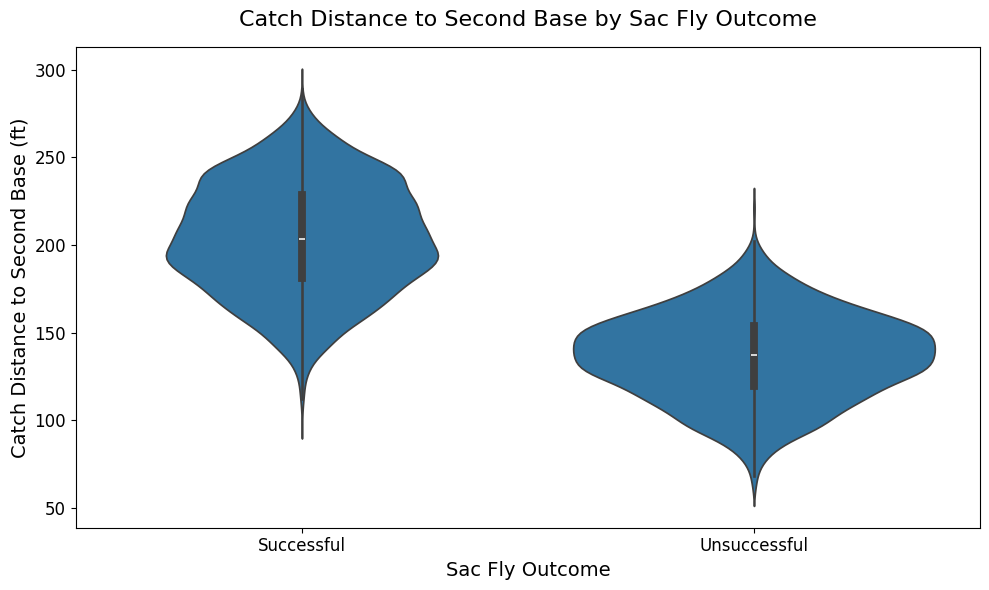

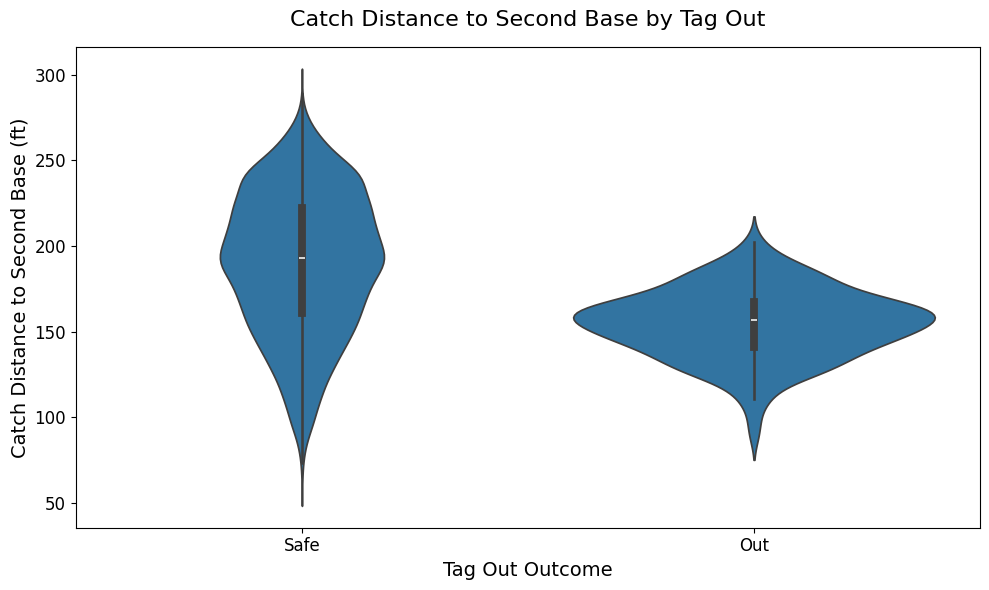

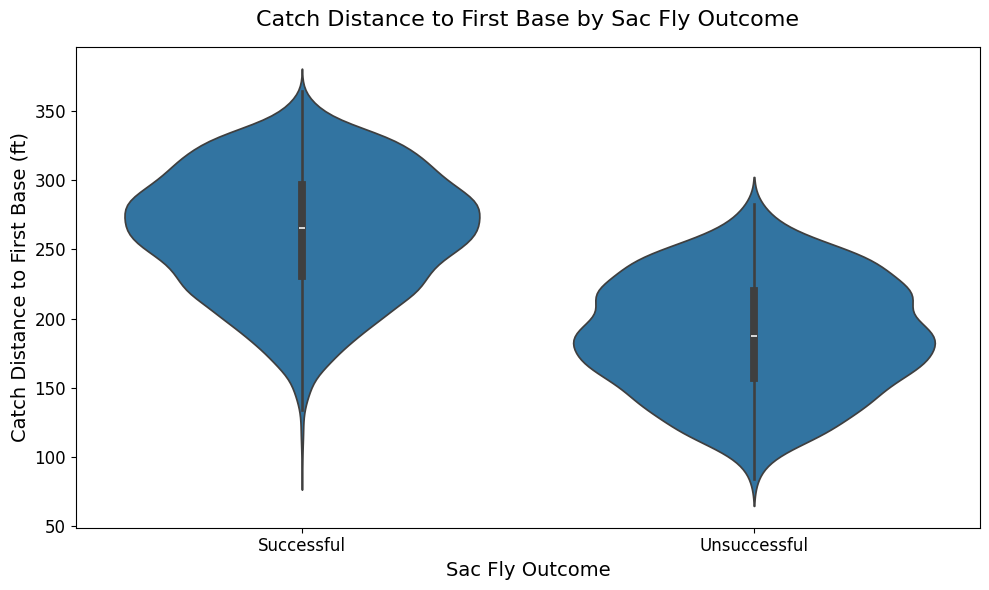

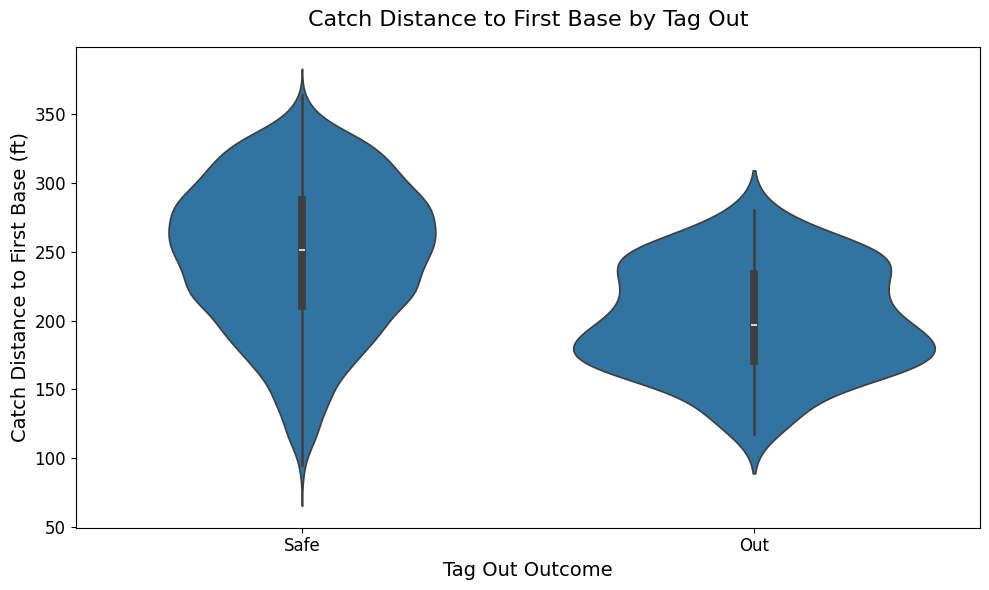

In [16]:
successful_dict = {
    "true": "Successful",
    "false": "Unsuccessful"
}

distance_features = ["distance_catch_to_home", "distance_catch_to_third", 
                     "distance_catch_to_second", "distance_catch_to_first",
                     "distance_traveled_fielder", "distance_traveled_all_fielders",
                     "distance_to_home_diff"]

distances_pd = (on_base_lf
    .select(distance_features + ["is_out", "is_successful"])
    .with_columns(
        pl.when(pl.col("is_out") == True)
          .then(pl.lit("Out"))
          .otherwise(pl.lit("Safe"))
          .alias("is_out"),
        pl.col("is_successful").cast(pl.String).replace(successful_dict)
    )
    .collect()
    .to_pandas()
)

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x= "is_successful", y='distance_catch_to_home', data=distances_pd)

# Formatting the plot
plt.title("Catch Distance to Home by Sac Fly Outcome", fontsize=16, pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Sac Fly Outcome", fontsize=14)
plt.ylabel("Catch Distance to Home Plate (ft)", fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x= "is_out", y='distance_catch_to_home', data=distances_pd)

# Formatting the plot
plt.title("Catch Distance to Home by Tag Out", fontsize=16, pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Tag Out Outcome", fontsize=14)
plt.ylabel("Catch Distance to Home Plate (ft)", fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

# Distance to Third Base Plots
# Create the violin plot by sac fly outcome
plt.figure(figsize=(10, 6))
sns.violinplot(x="is_successful", y='distance_catch_to_third', data=distances_pd)
# Formatting the plot
plt.title("Catch Distance to Third Base by Sac Fly Outcome", fontsize=16, pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Sac Fly Outcome", fontsize=14)
plt.ylabel("Catch Distance to Third Base (ft)", fontsize=14)
# Show the plot
plt.tight_layout()
plt.show()

# Create the violin plot by tag out outcome
plt.figure(figsize=(10, 6))
sns.violinplot(x="is_out", y='distance_catch_to_third', data=distances_pd)
# Formatting the plot
plt.title("Catch Distance to Third Base by Tag Out", fontsize=16, pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Tag Out Outcome", fontsize=14)
plt.ylabel("Catch Distance to Third Base (ft)", fontsize=14)
# Show the plot
plt.tight_layout()
plt.show()

# Distance to Second Base Plots
# Create the violin plot by sac fly outcome
plt.figure(figsize=(10, 6))
sns.violinplot(x="is_successful", y='distance_catch_to_second', data=distances_pd)
# Formatting the plot
plt.title("Catch Distance to Second Base by Sac Fly Outcome", fontsize=16, pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Sac Fly Outcome", fontsize=14)
plt.ylabel("Catch Distance to Second Base (ft)", fontsize=14)
# Show the plot
plt.tight_layout()
plt.show()

# Create the violin plot by tag out outcome
plt.figure(figsize=(10, 6))
sns.violinplot(x="is_out", y='distance_catch_to_second', data=distances_pd)
# Formatting the plot
plt.title("Catch Distance to Second Base by Tag Out", fontsize=16, pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Tag Out Outcome", fontsize=14)
plt.ylabel("Catch Distance to Second Base (ft)", fontsize=14)
# Show the plot
plt.tight_layout()
plt.show()

# Distance to First Base Plots
# Create the violin plot by sac fly outcome
plt.figure(figsize=(10, 6))
sns.violinplot(x="is_successful", y='distance_catch_to_first', data=distances_pd)
# Formatting the plot
plt.title("Catch Distance to First Base by Sac Fly Outcome", fontsize=16, pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Sac Fly Outcome", fontsize=14)
plt.ylabel("Catch Distance to First Base (ft)", fontsize=14)
# Show the plot
plt.tight_layout()
plt.show()

# Create the violin plot by tag out outcome
plt.figure(figsize=(10, 6))
sns.violinplot(x="is_out", y='distance_catch_to_first', data=distances_pd)
# Formatting the plot
plt.title("Catch Distance to First Base by Tag Out", fontsize=16, pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Tag Out Outcome", fontsize=14)
plt.ylabel("Catch Distance to First Base (ft)", fontsize=14)
# Show the plot
plt.tight_layout()
plt.show()

### Outfielder Distance Traveled From Batted to Catch

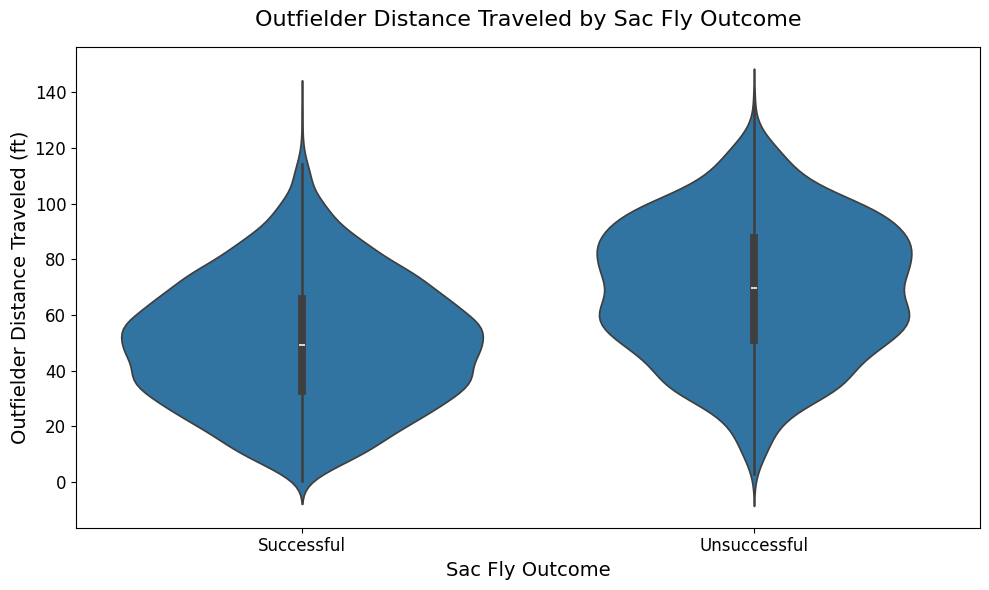

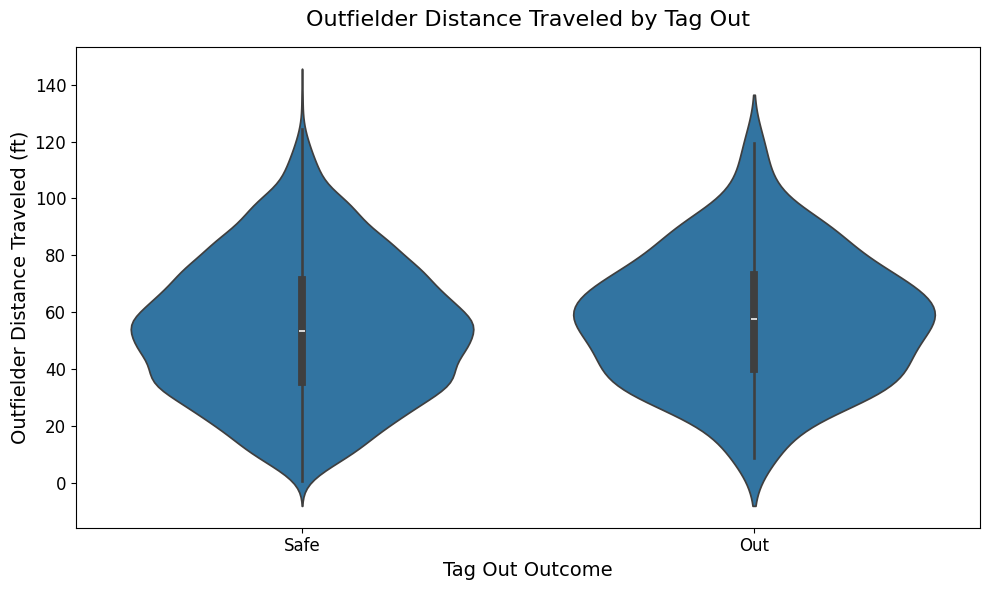

In [17]:
# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x= "is_successful", y='distance_traveled_fielder', data=distances_pd)

# Formatting the plot
plt.title("Outfielder Distance Traveled by Sac Fly Outcome", fontsize=16, pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Sac Fly Outcome", fontsize=14)
plt.ylabel("Outfielder Distance Traveled (ft)", fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x= "is_out", y='distance_traveled_fielder', data=distances_pd)

# Formatting the plot
plt.title("Outfielder Distance Traveled by Tag Out", fontsize=16, pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Tag Out Outcome", fontsize=14)
plt.ylabel("Outfielder Distance Traveled (ft)", fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

### Outfielder Distance to Home Difference

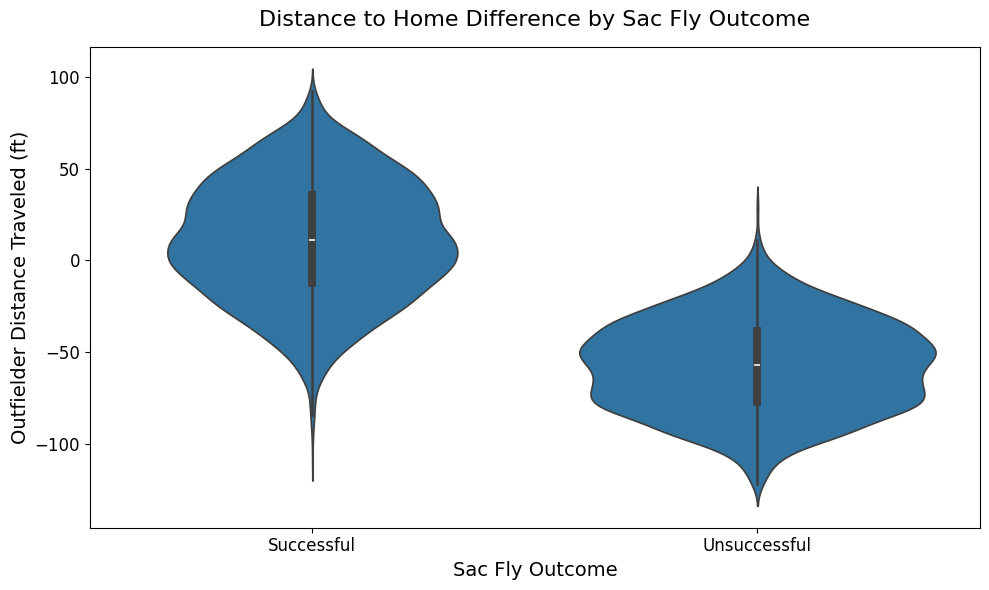

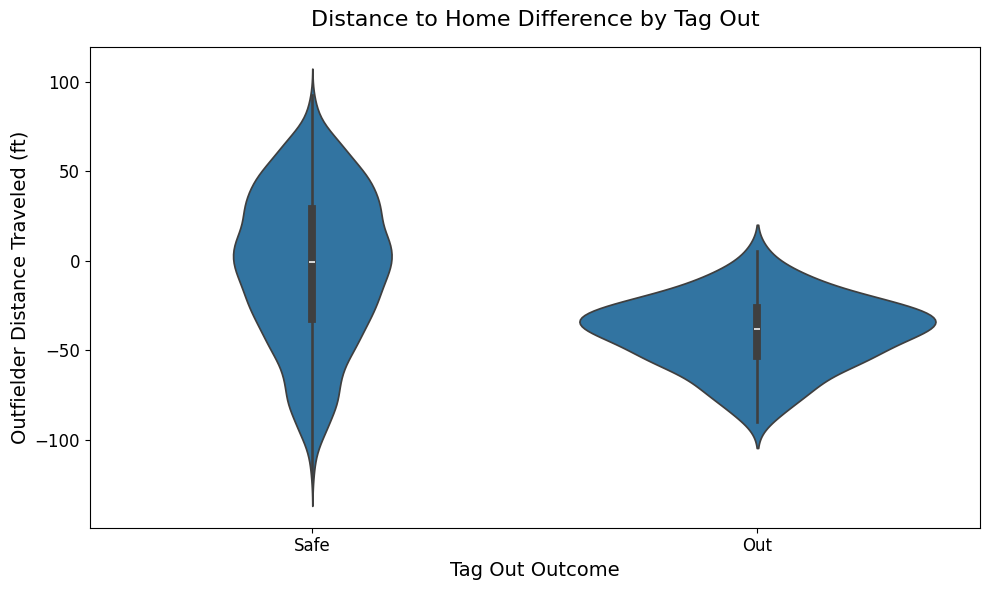

In [18]:
# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x= "is_successful", y='distance_to_home_diff', data=distances_pd)

# Formatting the plot
plt.title("Distance to Home Difference by Sac Fly Outcome", fontsize=16, pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Sac Fly Outcome", fontsize=14)
plt.ylabel("Outfielder Distance Traveled (ft)", fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x= "is_out", y='distance_to_home_diff', data=distances_pd)

# Formatting the plot
plt.title("Distance to Home Difference by Tag Out", fontsize=16, pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Tag Out Outcome", fontsize=14)
plt.ylabel("Outfielder Distance Traveled (ft)", fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

### Distance Traveled by All Fielders

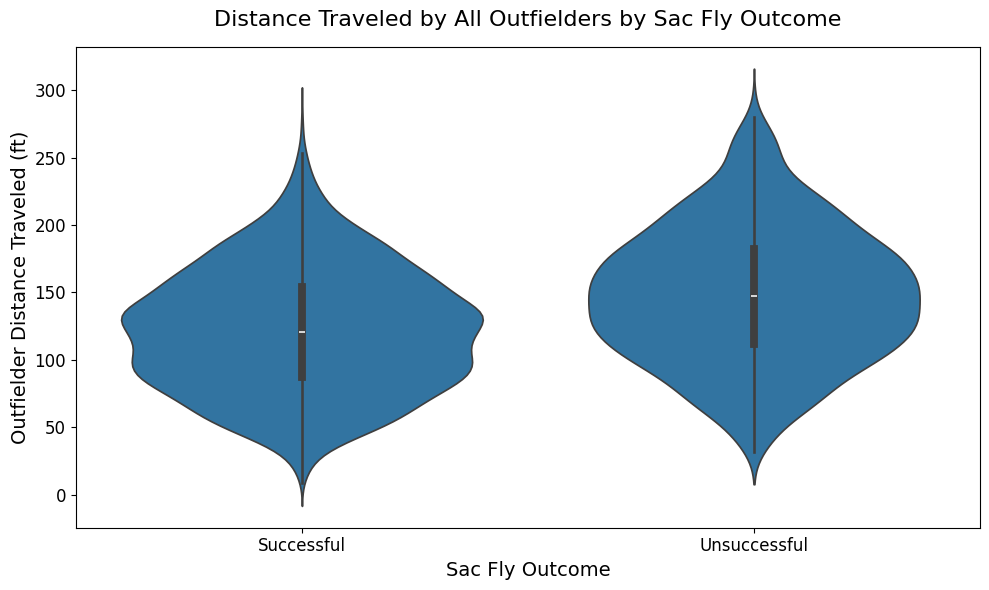

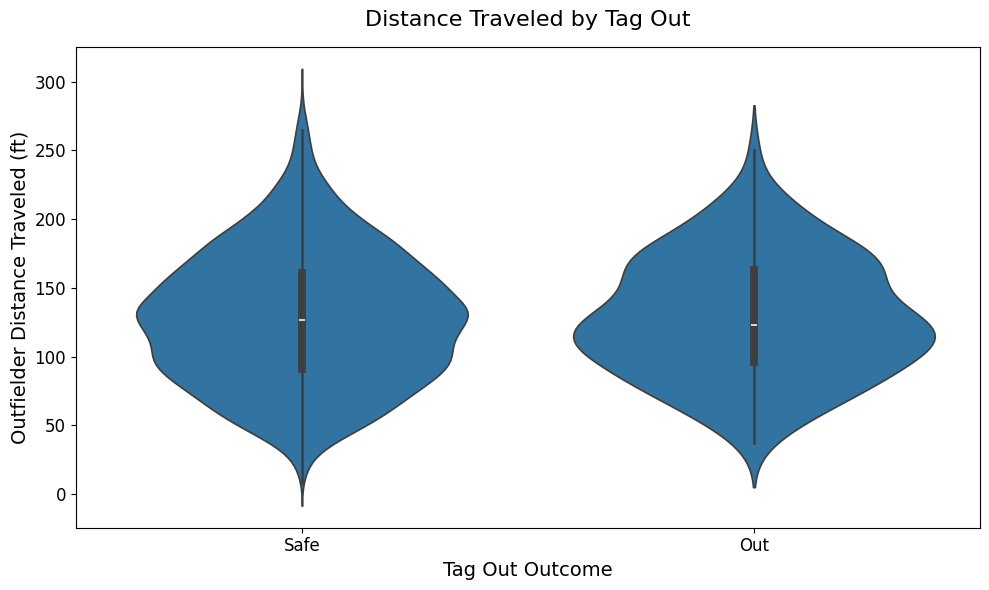

In [19]:
# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x= "is_successful", y='distance_traveled_all_fielders', data=distances_pd)

# Formatting the plot
plt.title("Distance Traveled by All Outfielders by Sac Fly Outcome", fontsize=16, pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Sac Fly Outcome", fontsize=14)
plt.ylabel("Outfielder Distance Traveled (ft)", fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x= "is_out", y='distance_traveled_all_fielders', data=distances_pd)

# Formatting the plot
plt.title("Distance Traveled by Tag Out", fontsize=16, pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Tag Out Outcome", fontsize=14)
plt.ylabel("Outfielder Distance Traveled (ft)", fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

## Modeling - Unmodified Play Outcomes

Predicting the probability of Tag Out and evaluating using brier score and log-loss

### All Parameters Unmodified Tag Out

#### Predictors and Grid Search Parameters

In [21]:
# Feature column names
responses = ["is_out"]

num_predictors_drop = [
    "hang_time",
  "distance_catch_to_home",
  "distance_traveled_fielder",
  "distance_traveled_all_fielders",
  "distance_to_home_diff",
  "distance_catch_to_first",
  "distance_catch_to_second",
  "distance_catch_to_third"
]

num_predictors_median = [
    "seconds_since_hit_085_mlb_person_id_R3",
    "arm_overall_fielder_mlb_person_id",
]

# Scoring method
specificity_scorer = make_scorer(recall_score, pos_label=1)
precision_pos_scorer = make_scorer(precision_score, pos_label=1, zero_division=0)
f1_pos_scorer = make_scorer(f1_score, pos_label=1, zero_division=0)
scoring = {
    'log_loss': 'neg_log_loss',
    'brier_score': 'neg_brier_score'
}
refit = "brier_score"

# Parameter grids
logit_param_grid = {
    'classifier__penalty': ['elasticnet'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'classifier__solver': ['saga'],
    'classifier__max_iter': [100, 250, 500, 1000]
}

rf_param_grid = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [None, 20],
    'classifier__min_samples_split': [2, 10],
    'classifier__min_samples_leaf': [1, 4],
    'classifier__max_features': ['sqrt', None],
    'classifier__random_state': [42]
}

xg_param_grid = {
    'classifier__n_estimators': [100, 500],
    'classifier__max_depth': [3, 10],
    'classifier__learning_rate': [0.01, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__max_features': ['sqrt', None],
    'classifier__min_samples_split': [2, 10],
    'classifier__random_state': [42]
}

mlp_param_grid = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'classifier__activation': ['relu', 'tanh'],
    'classifier__solver': ['adam', 'lbfgs'],
    'classifier__alpha': [0.001, 0.01],
    'classifier__max_iter': [500, 1000],
    'classifier__random_state': [42]
}


#### Logistic Regression - All Predictors and Unmodified Tag Out

In [ ]:
# Prepare GridSearch
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="LogisticRegression",
    oversampling_method="SMOTE",
    param_grid=logit_param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Censored Train and Censored Test
results = model_prep_on_base(
    on_base_lf = on_base_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = False,
    test_stay_to_out = False,
    test_stay_to_out_threshold = False,
)

pipeline = results['pipeline']
X_train = results['X_train']
X_test = results['X_test']
y_train = results['y_train']
y_test = results['y_test']
y_pred = results['y_pred']
y_pred_proba = results['y_pred_proba']
brier_score = results['brier_score']
log_loss = results['log_loss']
feature_names = results['feature_names']
response_names = results['response_names']
threshold = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_pred_proba)], axis=1)
threshold = threshold[(threshold[0] > 0.49) & (threshold[0] < 0.50)]
threshold
distance_catch_to_home_pd = X_test["distance_catch_to_home"]
plt.figure(figsize=(10, 6))
plt.scatter(distance_catch_to_home_pd, y_pred_proba, alpha=0.6, s=30)

# Create decision boundary lines that only extend to the intersection point
# Vertical line from bottom to y=0.5
plt.plot([265, 265], [0, 0.5], color='red', linestyle='--', linewidth=2, label='Decision Boundary')
# Horizontal line from left edge to x=265
plt.plot([0, 265], [0.5, 0.5], color='red', linestyle='--', linewidth=2)

# Add annotation with arrow pointing to the intersection
plt.annotate('Decision Boundary\n(265 ft, 50%)', 
             xy=(265, 0.5),  # Point to annotate (intersection)
             xytext=(350, 0.6),  # Text position (offset to the right and up)
             arrowprops=dict(arrowstyle='->', 
                           color='red', 
                           lw=1.5),
             fontsize=12,  # Consistent with labels
             ha='center',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.xlabel('Distance Catch to Home (ft)', fontsize=14)
plt.ylabel('Predicted Probability of Tag Out', fontsize=14)
plt.title('Model Predicted Probability by Distance From Catch to Home', fontsize=16)
plt.xlim([0, 450])
plt.ylim([0, 1])
plt.legend(fontsize=14)
plt.grid(True, alpha=0.3)

# Make tick labels consistent too
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

Total features: 11
Total Predictors: 10
Total Responses: 1
Fitting 5 folds for each of 120 candidates, totalling 600 fits


/home/taylorswrite/git/Sacrifice-Fly-Modeling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/taylorswrite/git/Sacrifice-Fly-Modeling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/taylorswrite/git/Sacrifice-Fly-Modeling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/taylorswrite/git/Sacrifice-Fly-Modeling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/taylorswrite/git/Sacrifice-Fly-Modeling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: T


Best parameters: 
classifier__C = 100
classifier__l1_ratio = 0.9
classifier__max_iter = 1000
classifier__penalty = elasticnet
classifier__solver = saga

Best cross-validation score: -0.1002

              precision    recall  f1-score   support

       False       0.99      0.87      0.93      1444
        True       0.15      0.81      0.26        42

    accuracy                           0.87      1486
   macro avg       0.57      0.84      0.59      1486
weighted avg       0.97      0.87      0.91      1486

Brier Score: 0.0988
log loss: 0.3322

Predictors:
hang_time
distance_catch_to_home
distance_traveled_fielder
distance_traveled_all_fielders
distance_to_home_diff
distance_catch_to_first
distance_catch_to_second
distance_catch_to_third
seconds_since_hit_085_mlb_person_id_R3
arm_overall_fielder_mlb_person_id

Response:
is_out


/home/taylorswrite/git/Sacrifice-Fly-Modeling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### Random Forest - All Predictors and Unmodified Tag Out

In [21]:
# Prepare GridSearch
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="RandomForestClassifier",
    oversampling_method="SMOTE",
    param_grid=rf_param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Censored Train and Censored Test
results = model_prep_on_base(
    on_base_lf = on_base_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = False,
    test_stay_to_out = False,
    test_stay_to_out_threshold = False,
)

Total features: 11
Total Predictors: 10
Total Responses: 1
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters: 
classifier__max_depth = None
classifier__max_features = sqrt
classifier__min_samples_leaf = 1
classifier__min_samples_split = 2
classifier__n_estimators = 200
classifier__random_state = 42

Best cross-validation score: -0.0447

              precision    recall  f1-score   support

       False       0.98      0.94      0.96      1444
        True       0.17      0.40      0.24        42

    accuracy                           0.93      1486
   macro avg       0.57      0.67      0.60      1486
weighted avg       0.96      0.93      0.94      1486

Brier Score: 0.0490
log loss: 0.1508

Predictors:
hang_time
distance_catch_to_home
distance_traveled_fielder
distance_traveled_all_fielders
distance_to_home_diff
distance_catch_to_first
distance_catch_to_second
distance_catch_to_third
seconds_since_hit_085_mlb_person_id_R3
arm_overall_fielder_mlb_person_

#### XGBoost - All Predictors and Unmodified Tag Out

In [22]:
# Prepare GridSearch
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="GradientBoostingClassifier",
    oversampling_method="SMOTE",
    param_grid=xg_param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Censored Train and Censored Test
results = model_prep_on_base(
    on_base_lf = on_base_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = False,
    test_stay_to_out = False,
    test_stay_to_out_threshold = False,
)

Total features: 11
Total Predictors: 10
Total Responses: 1
Fitting 5 folds for each of 64 candidates, totalling 320 fits

Best parameters: 
classifier__learning_rate = 0.01
classifier__max_depth = 10
classifier__max_features = sqrt
classifier__min_samples_split = 10
classifier__n_estimators = 500
classifier__random_state = 42
classifier__subsample = 1.0

Best cross-validation score: -0.0496

              precision    recall  f1-score   support

       False       0.98      0.94      0.96      1444
        True       0.18      0.43      0.25        42

    accuracy                           0.93      1486
   macro avg       0.58      0.69      0.61      1486
weighted avg       0.96      0.93      0.94      1486

Brier Score: 0.0557
log loss: 0.1816

Predictors:
hang_time
distance_catch_to_home
distance_traveled_fielder
distance_traveled_all_fielders
distance_to_home_diff
distance_catch_to_first
distance_catch_to_second
distance_catch_to_third
seconds_since_hit_085_mlb_person_id_R3
arm_

#### MLP - All Predictors and Unmodified Tag Out

In [23]:
# Prepare GridSearch
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="MLPClassifier",
    oversampling_method="SMOTE",
    param_grid=mlp_param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Censored Train and Censored Test
results = model_prep_on_base(
    on_base_lf = on_base_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = True,
    test_stay_to_out = False,
    test_stay_to_out_threshold = True,
)

Total features: 11
Total Predictors: 10
Total Responses: 1
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/taylorswrite/git/Sacrifice-Fly-Modeling/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/taylorswrite/git/Sacrifice-Fly-Modeling/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/taylorswrite/git/Sacrifice-Fly-Modeling/.venv/lib/python3.11/site-packages/sklearn/neural_netw


Best parameters: 
classifier__activation = relu
classifier__alpha = 0.001
classifier__hidden_layer_sizes = (50,)
classifier__max_iter = 500
classifier__random_state = 42
classifier__solver = adam

Best cross-validation score: -0.0479

              precision    recall  f1-score   support

       False       0.97      0.94      0.96      1444
        True       0.78      0.89      0.83       342

    accuracy                           0.93      1786
   macro avg       0.88      0.91      0.89      1786
weighted avg       0.94      0.93      0.93      1786

Brier Score: 0.0559
log loss: 0.2172

Predictors:
hang_time
distance_catch_to_home
distance_traveled_fielder
distance_traveled_all_fielders
distance_to_home_diff
distance_catch_to_first
distance_catch_to_second
distance_catch_to_third
seconds_since_hit_085_mlb_person_id_R3
arm_overall_fielder_mlb_person_id

Response:
is_out


### Limited Predictors and Unmodified Tag Outs

#### Predictors and Grid Search

In [24]:
# Feature column names
responses = ["is_out"]

num_predictors_drop = [
  "distance_catch_to_home",
]

num_predictors_median = [
]

# Scoring method
specificity_scorer = make_scorer(recall_score, pos_label=1)
precision_pos_scorer = make_scorer(precision_score, pos_label=1, zero_division=0)
f1_pos_scorer = make_scorer(f1_score, pos_label=1, zero_division=0)
scoring = {
    'log_loss': 'neg_log_loss',
    'brier_score': 'neg_brier_score'
}
refit = "brier_score"

# Parameter grids
logit_param_grid = {
    'classifier__penalty': ['elasticnet'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'classifier__solver': ['saga'],
    'classifier__max_iter': [100, 250, 500, 1000]
}

rf_param_grid = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [None, 20],
    'classifier__min_samples_split': [2, 10],
    'classifier__min_samples_leaf': [1, 4],
    'classifier__max_features': ['sqrt', None],
    'classifier__random_state': [42]
}

xg_param_grid = {
    'classifier__n_estimators': [100, 500],
    'classifier__max_depth': [3, 10],
    'classifier__learning_rate': [0.01, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__max_features': ['sqrt', None],
    'classifier__min_samples_split': [2, 10],
    'classifier__random_state': [42]
}

mlp_param_grid = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'classifier__activation': ['relu', 'tanh'],
    'classifier__solver': ['adam', 'lbfgs'],
    'classifier__alpha': [0.001, 0.01],
    'classifier__max_iter': [500, 1000],
    'classifier__random_state': [42]
}


#### Logistic Regression - Limited Predictors and Unmodified Tag Out

In [25]:
# Prepare GridSearch
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="LogisticRegression",
    oversampling_method="SMOTE",
    param_grid=logit_param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Censored Train and Censored Test
results = model_prep_on_base(
    on_base_lf = on_base_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = False,
    test_stay_to_out = False,
    test_stay_to_out_threshold = False,
)

Total features: 2
Total Predictors: 1
Total Responses: 1
Fitting 5 folds for each of 120 candidates, totalling 600 fits

Best parameters: 
classifier__C = 100
classifier__l1_ratio = 0.9
classifier__max_iter = 100
classifier__penalty = elasticnet
classifier__solver = saga

Best cross-validation score: -0.1208

              precision    recall  f1-score   support

       False       1.00      0.83      0.91      1450
        True       0.13      0.86      0.22        42

    accuracy                           0.83      1492
   macro avg       0.56      0.84      0.57      1492
weighted avg       0.97      0.83      0.89      1492

Brier Score: 0.1195
log loss: 0.3822

Predictors:
distance_catch_to_home

Response:
is_out


#### Random Forest - Limited Predictors and Unmodified Tag Out

In [26]:
# Prepare GridSearch
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="RandomForestClassifier",
    oversampling_method="SMOTE",
    param_grid=rf_param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Censored Train and Censored Test
results = model_prep_on_base(
    on_base_lf = on_base_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = False,
    test_stay_to_out = False,
    test_stay_to_out_threshold = False,
)

Total features: 2
Total Predictors: 1
Total Responses: 1
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters: 
classifier__max_depth = 20
classifier__max_features = sqrt
classifier__min_samples_leaf = 4
classifier__min_samples_split = 10
classifier__n_estimators = 200
classifier__random_state = 42

Best cross-validation score: -0.1195

              precision    recall  f1-score   support

       False       0.99      0.84      0.91      1450
        True       0.10      0.64      0.18        42

    accuracy                           0.83      1492
   macro avg       0.55      0.74      0.54      1492
weighted avg       0.96      0.83      0.89      1492

Brier Score: 0.1189
log loss: 0.6578

Predictors:
distance_catch_to_home

Response:
is_out


#### XGBoost - Limited Predictors and Unmodified Tag Out

In [27]:
# Prepare GridSearch
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="GradientBoostingClassifier",
    oversampling_method="SMOTE",
    param_grid=xg_param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Censored Train and Censored Test
results = model_prep_on_base(
    on_base_lf = on_base_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = False,
    test_stay_to_out = False,
    test_stay_to_out_threshold = False,
)

Total features: 2
Total Predictors: 1
Total Responses: 1
Fitting 5 folds for each of 64 candidates, totalling 320 fits

Best parameters: 
classifier__learning_rate = 0.2
classifier__max_depth = 3
classifier__max_features = sqrt
classifier__min_samples_split = 2
classifier__n_estimators = 100
classifier__random_state = 42
classifier__subsample = 1.0

Best cross-validation score: -0.1125

              precision    recall  f1-score   support

       False       0.99      0.82      0.90      1450
        True       0.11      0.76      0.19        42

    accuracy                           0.82      1492
   macro avg       0.55      0.79      0.55      1492
weighted avg       0.97      0.82      0.88      1492

Brier Score: 0.1180
log loss: 0.3452

Predictors:
distance_catch_to_home

Response:
is_out


#### MLP - Limited Predictors and Unmodified Tag Out

In [28]:
# Prepare GridSearch
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="MLPClassifier",
    oversampling_method="SMOTE",
    param_grid=mlp_param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Censored Train and Censored Test
results = model_prep_on_base(
    on_base_lf = on_base_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = False,
    test_stay_to_out = False,
    test_stay_to_out_threshold = False,
)

Total features: 2
Total Predictors: 1
Total Responses: 1
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/taylorswrite/git/Sacrifice-Fly-Modeling/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/taylorswrite/git/Sacrifice-Fly-Modeling/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/taylorswrite/git/Sacrifice-Fly-Modeling/.venv/lib/python3.11/site-packages/sklearn/neural_netw


Best parameters: 
classifier__activation = tanh
classifier__alpha = 0.01
classifier__hidden_layer_sizes = (100, 50)
classifier__max_iter = 1000
classifier__random_state = 42
classifier__solver = lbfgs

Best cross-validation score: -0.1216

              precision    recall  f1-score   support

       False       0.99      0.82      0.90      1450
        True       0.12      0.83      0.21        42

    accuracy                           0.82      1492
   macro avg       0.56      0.83      0.55      1492
weighted avg       0.97      0.82      0.88      1492

Brier Score: 0.1248
log loss: 0.3558

Predictors:
distance_catch_to_home

Response:
is_out


/home/taylorswrite/git/Sacrifice-Fly-Modeling/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


## Censoring - Stay to Out Threshold

### Create Outcome Variable for Plotting

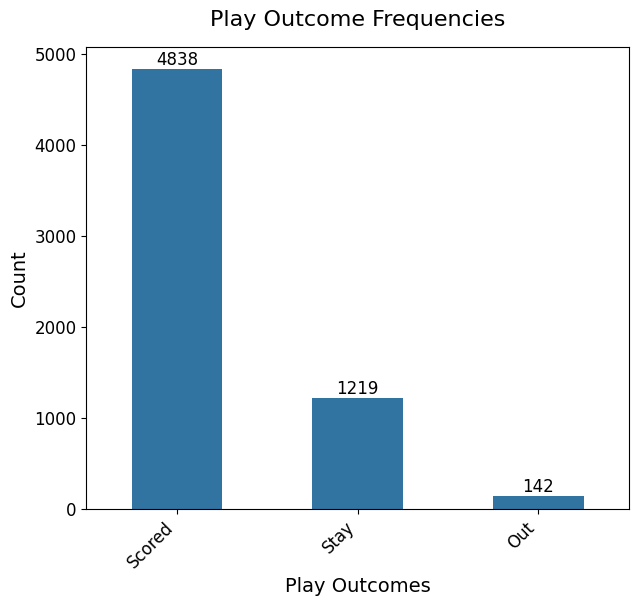

In [21]:
on_base_outcomes_lf = (on_base_lf
    .with_columns(
        pl.when(pl.col("is_out") == True)
          .then(pl.lit("Out"))
          .when(pl.col("is_advance") == True)
          .then(pl.lit("Scored"))
          .when(pl.col("is_stay") == True)
          .then(pl.lit("Stay"))
          .otherwise(None)
          .alias("outcome")
    )
)
on_base_outcomes_pd = on_base_outcomes_lf.collect().to_pandas()
plt.figure(figsize=(7, 6))
ax = sns.countplot(x="outcome", data=on_base_outcomes_pd, width=.5)  # Add ax = here
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=12)
plt.title("Play Outcome Frequencies", fontsize=16, pad=15)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.xlabel("Play Outcomes", fontsize=14)
plt.ylabel("Count", fontsize=14)  # Also fixed this to match what you're plotting
plt.show()

### Baseline Histogram of Catch Distance to Home by Play Outcome

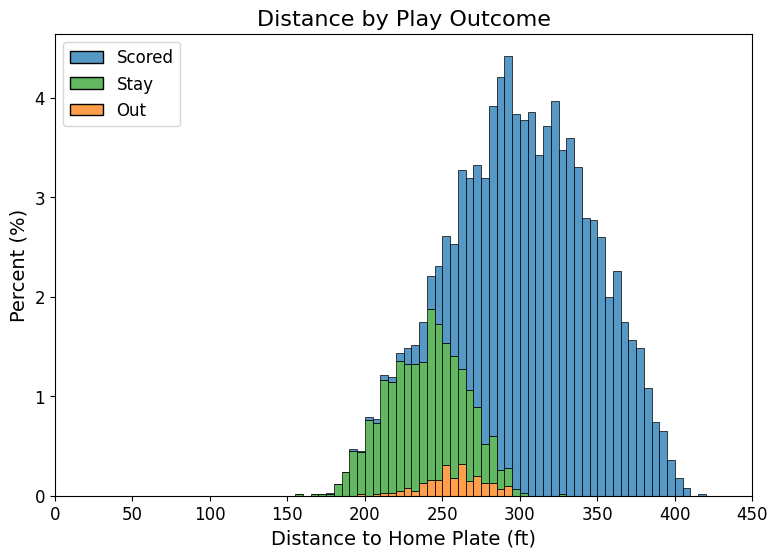

In [29]:
colors = sns.color_palette()
blue = colors[0]
yellow = colors[1]
green = colors[2]
pink = colors[6]

# Create stacked histogram
plt.figure(figsize=(9, 6))
ax = sns.histplot(data=on_base_outcomes_pd, 
                 x="distance_catch_to_home", 
                 hue="outcome",
                 stat="percent", 
                 binrange=(0, 450),
                 binwidth=5,
                 palette=[blue,green,yellow],
                 multiple="stack")

# Save the legend for later
legend = ax.get_legend()
handles = legend.legend_handles
labels = [t.get_text() for t in legend.get_texts()]

# Create legend with each part
plt.legend(handles, labels, loc='upper left', fontsize=12, title_fontsize=14)

# Plot Formatting
plt.title('Distance by Play Outcome', fontsize=16)
plt.xlabel('Distance to Home Plate (ft)', fontsize=14)
plt.ylabel('Percent (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 450)

plt.show()

### Problem: What the Model is Sees

In [30]:
combined_binary_lf = (on_base_outcomes_lf
    .with_columns(
        pl.when(pl.col("outcome") != pl.lit("Out"))
        .then(pl.lit("Safe"))
        .otherwise(pl.col("outcome"))
        .alias("outcome")
    )
) 

combined_binary_pd = combined_binary_lf.collect().to_pandas()

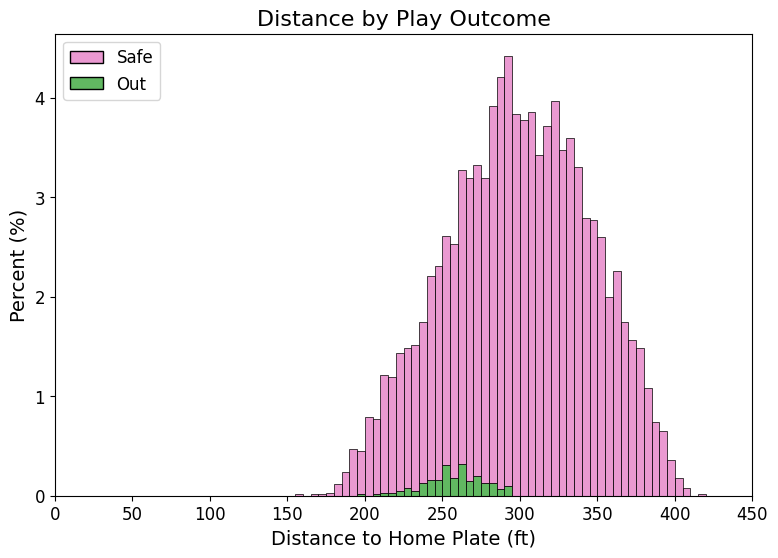

In [31]:
# Create stacked histogram
plt.figure(figsize=(9, 6))
ax = sns.histplot(data=combined_binary_pd, 
                 x="distance_catch_to_home", 
                 hue="outcome",
                 stat="percent", 
                 binrange=(0, 450),
                 binwidth=5,
                 palette=[pink, green],
                 multiple="stack")

legend = ax.get_legend()
handles = legend.legend_handles
labels = [t.get_text() for t in legend.get_texts()]

plt.legend(handles, labels, loc='upper left', fontsize=12, title_fontsize=14)

# Plot Formatting
plt.title('Distance by Play Outcome', fontsize=16)
plt.xlabel('Distance to Home Plate (ft)', fontsize=14)
plt.ylabel('Percent (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 450)
plt.show()

In [32]:
on_base_outcomes_y_pd = on_base_outcomes_lf.select(["outcome"]).collect().to_pandas()
on_base_outcomes_X_pd = on_base_outcomes_lf.drop(["outcome"]).collect().to_pandas()
X_logit, X_bootstrap, y_logit, y_bootstrap = train_test_split(
    on_base_outcomes_X_pd, on_base_outcomes_y_pd, 
    test_size=0.20,  # Model2 gets 40%, Model1 gets 60%
    stratify=on_base_outcomes_y_pd,
    shuffle=True,
    random_state=123
)

print(f"Logit Set:  \n{y_logit.value_counts().sort_index()}\n{y_logit.value_counts(normalize=True).sort_index()}")
print(f"\nBootstrap Set:  \n{y_bootstrap.value_counts().sort_index()}\n{y_bootstrap.value_counts(normalize=True).sort_index()}")


bootstrap_set_pd = pd.concat([X_bootstrap, y_bootstrap], axis=1)
bootstrap_out_pd = bootstrap_set_pd.query("outcome == 'Out'")["distance_catch_to_home"]
bootstrap_sty_pd = bootstrap_set_pd.query("outcome == 'Stay'")["distance_catch_to_home"]
bootstrap_scr_pd = bootstrap_set_pd.query("outcome == 'Scored'")["distance_catch_to_home"].dropna()

logit_set_pd = pd.concat([X_logit, y_logit], axis=1)


Logit Set:  
outcome
Out         114
Scored     3870
Stay        975
Name: count, dtype: int64
outcome
Out        0.022989
Scored     0.780399
Stay       0.196612
Name: proportion, dtype: float64

Bootstrap Set:  
outcome
Out         28
Scored     968
Stay       244
Name: count, dtype: int64
outcome
Out        0.022581
Scored     0.780645
Stay       0.196774
Name: proportion, dtype: float64


In [33]:
# # Define your test statistic function
# def difference_in_means(x, y):
#     return np.mean(x) - np.mean(y)
# 
# # Perform the permutation test
# result = stats.permutation_test(
#     (bootstrap_out_pd, bootstrap_sty_pd),
#     difference_in_means,
#     n_resamples=10000,
#     alternative='two-sided'  # assuming out distances are smaller
# )
# 
# print("Permutation Test")
# print(f"Observed statistic: {result.statistic}")
# print(f"P-value: {result.pvalue}")

# Mann-Whitney U Test
print("Mann-Whitney: the distances for out outcomes were not greater than stay")
statistic, p_value = stats.mannwhitneyu(
    bootstrap_out_pd, 
    bootstrap_sty_pd,
    alternative='greater'  # assuming out distances are smaller than stay distances
)

print(f"Mann-Whitney U statistic: {statistic}")
print(f"P-value: {p_value}")

Mann-Whitney: the distances for out outcomes were not greater than stay
Mann-Whitney U statistic: 5194.0
P-value: 3.26231798160699e-06


### Bootstrap 95% CI of the Mean

In [34]:
bootstrap_pd = pl.LazyFrame(pd.concat([X_bootstrap, y_bootstrap], axis=1))
out_pd = bootstrap_pd.filter(pl.col("outcome") == pl.lit("Out"))
out_np = out_pd.select(["distance_catch_to_home"]).collect().to_numpy().flatten()

def bootstrap_upper_one_sided_ci(data, confidence=0.95, n_bootstrap=10000):
    """
    Calculate upper one-sided confidence interval using bootstrap
    """
    bootstrap_means = []
    n = len(data)
    ci = confidence * 100
    
    for _ in range(n_bootstrap):  # Fixed: was "n*bootstrap", now "n_bootstrap" with underscore
        sample = np.random.choice(data, size=n, replace=True)
        bootstrap_means.append(np.mean(sample))
    
    bound = np.percentile(bootstrap_means, ci)
    print(f"One-sided {confidence*100:.0f}% CI: mean ≤ {bound:.2f}")
    
    return bootstrap_means, bound

bootstrap_means, bound = bootstrap_upper_one_sided_ci(out_np)

One-sided 95% CI: mean ≤ 265.55


### Plot of Bootstrap 95% CI Mean

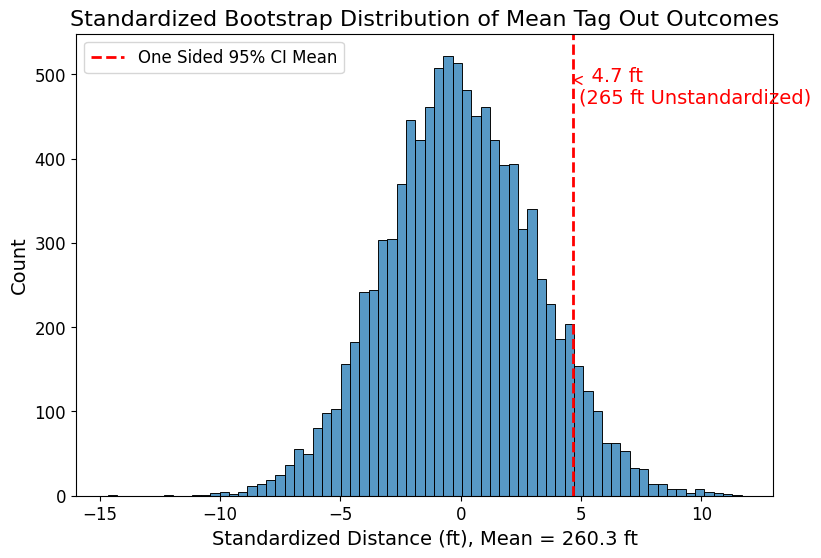

In [35]:
bootstrap_means_centered = bootstrap_means - np.mean(bootstrap_means)
reference_line = 265 - np.mean(bootstrap_means)
mean_value = np.mean(bootstrap_means)

plt.figure(figsize=(9, 6))
sns.histplot(bootstrap_means_centered)
plt.axvline(x=reference_line, color='red', linestyle='--', linewidth=2)
plt.annotate(f'  {reference_line:.1f} ft\n(265 ft Unstandardized)', 
           xy=(reference_line, plt.ylim()[1] * 0.90),  
           xytext=(reference_line + 0.25, plt.ylim()[1] * 0.85),  
           arrowprops=dict(arrowstyle='->', color='red'),
           fontsize=14,
           color='red')

# Create legend handles
from matplotlib.lines import Line2D
vline_handle = Line2D([0], [0], color='red', linestyle='--', linewidth=2)

# Add to legend with standardization info
plt.legend([vline_handle], 
          [f'One Sided 95% CI Mean'], 
          loc='upper left', 
          fontsize=12, 
          title_fontsize=14)

plt.title('Standardized Bootstrap Distribution of Mean Tag Out Outcomes', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(f'Standardized Distance (ft), Mean = {mean_value:.1f} ft', fontsize=14)
plt.show()

### Baseline Histogram with the Bootstrap 95% CI of Tag Outs

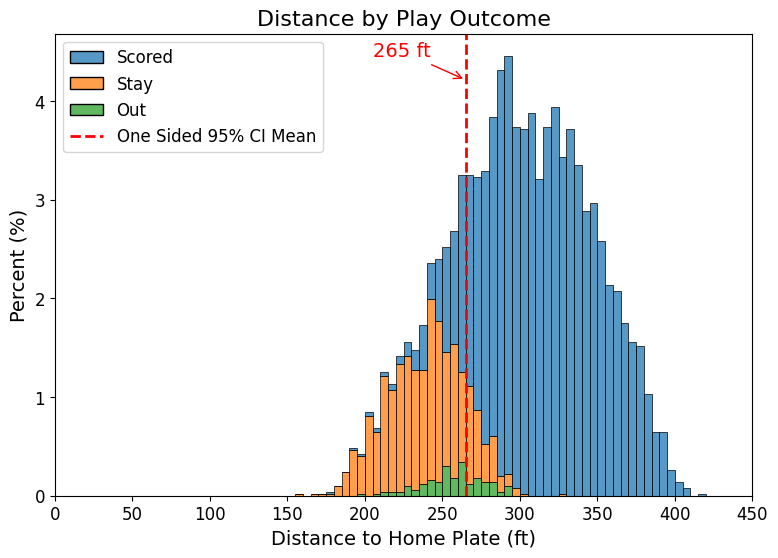

In [36]:
# Create stacked histogram
plt.figure(figsize=(9, 6))
ax = sns.histplot(data=logit_set_pd, 
                 x="distance_catch_to_home", 
                 hue="outcome",
                 stat="percent", 
                 binrange=(0, 450),
                 binwidth=5,
                 multiple="stack")

# Add vertical line and plot annotation
plt.axvline(x=265, color='red', linestyle='--', linewidth=2)
plt.annotate('265 ft', 
           xy=(265, plt.ylim()[1] * 0.90),  
           xytext=(265 - 60, plt.ylim()[1] * 0.95),  
           arrowprops=dict(arrowstyle='->', color='red'),
           fontsize=14,
           color='red')

# Save the legend for later
legend = ax.get_legend()
handles = legend.legend_handles
labels = [t.get_text() for t in legend.get_texts()]

# Add the vertical line to the legend
vline_handle = Line2D([0], [0], color='red', linestyle='--', linewidth=2)
handles.append(vline_handle)
labels.append('One Sided 95% CI Mean')

# Create legend with each part
plt.legend(handles, labels, loc='upper left', fontsize=12, title_fontsize=14)

# Plot Formatting
plt.title('Distance by Play Outcome', fontsize=16)
plt.xlabel('Distance to Home Plate (ft)', fontsize=14)
plt.ylabel('Percent (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 450)

plt.show()

### All points to the left of the 95% CI are considered Out

In [37]:
logit_set_lf = pl.LazyFrame(logit_set_pd)

censored_lf = logit_set_lf.with_columns(
    pl.when((pl.col("outcome") == pl.lit("Stay")) & (pl.col("distance_catch_to_home") <= 265))
    .then(pl.lit("Out"))
    .otherwise(pl.col("outcome"))
    .alias("outcome")
)
censored_pd = censored_lf.collect().to_pandas()

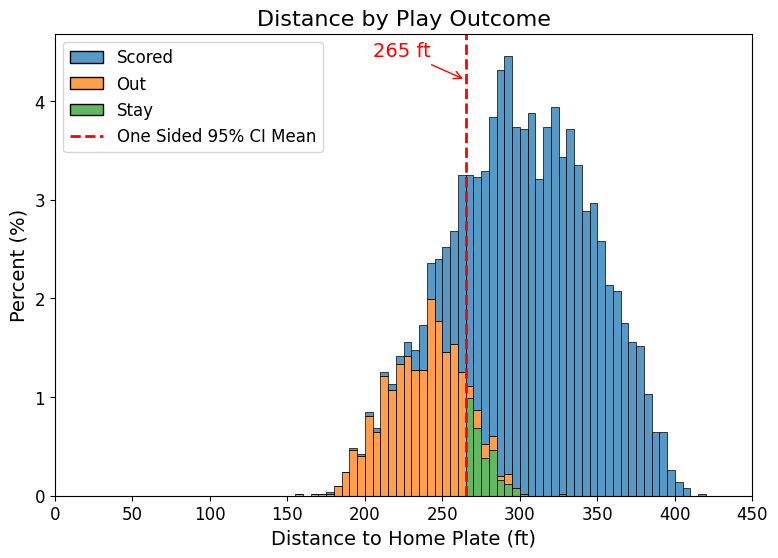

In [38]:
# Create stacked histogram
plt.figure(figsize=(9, 6))
ax = sns.histplot(data=censored_pd, 
                 x="distance_catch_to_home", 
                 hue="outcome",
                 stat="percent", 
                 binrange=(0, 450),
                 binwidth=5,
                 multiple="stack")

# Add vertical line and plot annotation
plt.axvline(x=265, color='red', linestyle='--', linewidth=2)
plt.annotate('265 ft', 
           xy=(265, plt.ylim()[1] * 0.90),  
           xytext=(265 - 60, plt.ylim()[1] * 0.95),  
           arrowprops=dict(arrowstyle='->', color='red'),
           fontsize=14,
           color='red')

# Save the legend for later
legend = ax.get_legend()
handles = legend.legend_handles
labels = [t.get_text() for t in legend.get_texts()]

# Add the vertical line to the legend
vline_handle = Line2D([0], [0], color='red', linestyle='--', linewidth=2)
handles.append(vline_handle)
labels.append('One Sided 95% CI Mean')

# Create legend with each part
plt.legend(handles, labels, loc='upper left', fontsize=12, title_fontsize=14)

# Plot Formatting
plt.title('Distance by Play Outcome', fontsize=16)
plt.xlabel('Distance to Home Plate (ft)', fontsize=14)
plt.ylabel('Percent (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 450)

plt.show()

### Solution - The distribution is more separable

In [39]:
censored_binary_lf = (censored_lf
    .with_columns(
        pl.when((pl.col("outcome") == pl.lit("Stay")) & (pl.col("distance_catch_to_home") <= 265))
          .then(pl.lit("Out"))
          .otherwise(pl.col("outcome"))
          .alias("outcome"))
    .with_columns(
        pl.when(pl.col("outcome") != pl.lit("Out"))
          .then(pl.lit("Safe"))
          .otherwise(pl.col("outcome"))
          .alias("outcome"))
)

censored_binary_pd = censored_binary_lf.collect().to_pandas()

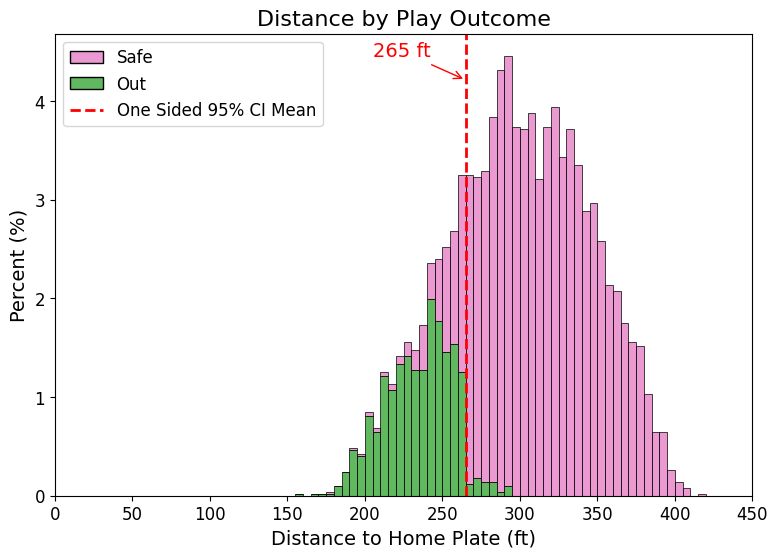

In [40]:
# Create stacked histogram
plt.figure(figsize=(9, 6))
ax = sns.histplot(data=censored_binary_pd, 
                 x="distance_catch_to_home", 
                 hue="outcome",
                 stat="percent", 
                 binrange=(0, 450),
                 binwidth=5,
                 palette=[pink, green],
                 multiple="stack")

# Add vertical line and plot annotation
plt.axvline(x=265, color='red', linestyle='--', linewidth=2)
plt.annotate('265 ft', 
           xy=(265, plt.ylim()[1] * 0.90),  
           xytext=(265 - 60, plt.ylim()[1] * 0.95),  
           arrowprops=dict(arrowstyle='->', color='red'),
           fontsize=14,
           color='red')

# Save the legend for later
legend = ax.get_legend()
handles = legend.legend_handles
labels = [t.get_text() for t in legend.get_texts()]

# Add the vertical line to the legend
vline_handle = Line2D([0], [0], color='red', linestyle='--', linewidth=2)
handles.append(vline_handle)
labels.append('One Sided 95% CI Mean')

# Create legend with each part
plt.legend(handles, labels, loc='upper left', fontsize=12, title_fontsize=14)

# Plot Formatting
plt.title('Distance by Play Outcome', fontsize=16)
plt.xlabel('Distance to Home Plate (ft)', fontsize=14)
plt.ylabel('Percent (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 450)

plt.show()

### Alternative - Converting All Stays to Outs

In [41]:
stay_to_out_lf = (logit_set_lf
    .with_columns(
        pl.when((pl.col("outcome") == pl.lit("Stay")) | (pl.col("outcome") == pl.lit("Out")))
        .then(pl.lit("Stay or Out"))
        .otherwise(pl.col("outcome"))
        .alias("outcome"))
    .with_columns(
        pl.when(pl.col("outcome") != pl.lit("Stay or Out"))
        .then(pl.lit("Scored"))
        .otherwise(pl.col("outcome"))
        .alias("outcome")
    )
)

stay_to_out_pd = stay_to_out_lf.collect().to_pandas()

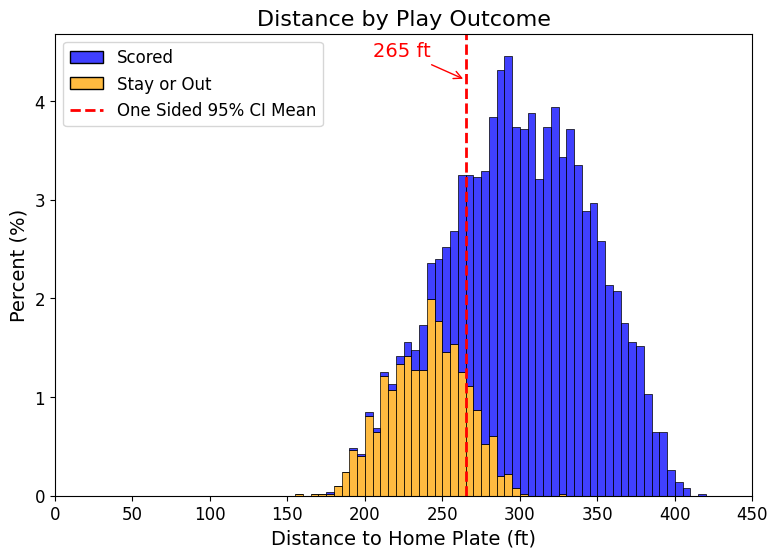

In [42]:
# Create stacked histogram
plt.figure(figsize=(9, 6))
ax = sns.histplot(data=stay_to_out_pd, 
                 x="distance_catch_to_home", 
                 hue="outcome",
                 stat="percent", 
                 binrange=(0, 450),
                 binwidth=5,
                 palette=["blue", "orange"],
                 multiple="stack")

# Add vertical line and plot annotation
plt.axvline(x=265, color='red', linestyle='--', linewidth=2)
plt.annotate('265 ft', 
           xy=(265, plt.ylim()[1] * 0.90),  
           xytext=(265 - 60, plt.ylim()[1] * 0.95),  
           arrowprops=dict(arrowstyle='->', color='red'),
           fontsize=14,
           color='red')

# Save the legend for later
legend = ax.get_legend()
handles = legend.legend_handles
labels = [t.get_text() for t in legend.get_texts()]

# Add the vertical line to the legend
vline_handle = Line2D([0], [0], color='red', linestyle='--', linewidth=2)
handles.append(vline_handle)
labels.append('One Sided 95% CI Mean')

# Create legend with each part
plt.legend(handles, labels, loc='upper left', fontsize=12, title_fontsize=14)

# Plot Formatting
plt.title('Distance by Play Outcome', fontsize=16)
plt.xlabel('Distance to Home Plate (ft)', fontsize=14)
plt.ylabel('Percent (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 450)

plt.show()

## Modeling - Applied Censoring Threshold

### All Parameters and Tag Out Threshold Censoring

#### Predictors and Grid Search

In [43]:
# Feature column names
responses = ["is_out"]

num_predictors_drop = [
    "hang_time",
  "distance_catch_to_home",
  "distance_traveled_fielder",
  "distance_traveled_all_fielders",
  "distance_to_home_diff",
  "distance_catch_to_first",
  "distance_catch_to_second",
  "distance_catch_to_third"
]

num_predictors_median = [
    "seconds_since_hit_085_mlb_person_id_R3",
    "arm_overall_fielder_mlb_person_id",
]

# Scoring method
specificity_scorer = make_scorer(recall_score, pos_label=1)
precision_pos_scorer = make_scorer(precision_score, pos_label=1, zero_division=0)
f1_pos_scorer = make_scorer(f1_score, pos_label=1, zero_division=0)
scoring = {
    'log_loss': 'neg_log_loss',
    'brier_score': 'neg_brier_score'
}
refit = "brier_score"

# Parameter grids
logit_param_grid = {
    'classifier__penalty': ['elasticnet'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'classifier__solver': ['saga'],
    'classifier__max_iter': [100, 250, 500, 1000]
}

rf_param_grid = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [None, 20],
    'classifier__min_samples_split': [2, 10],
    'classifier__min_samples_leaf': [1, 4],
    'classifier__max_features': ['sqrt', None],
    'classifier__random_state': [42]
}

xg_param_grid = {
    'classifier__n_estimators': [100, 500],
    'classifier__max_depth': [3, 10],
    'classifier__learning_rate': [0.01, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__max_features': ['sqrt', None],
    'classifier__min_samples_split': [2, 10],
    'classifier__random_state': [42]
}

mlp_param_grid = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'classifier__activation': ['relu', 'tanh'],
    'classifier__solver': ['adam', 'lbfgs'],
    'classifier__alpha': [0.001, 0.01],
    'classifier__max_iter': [500, 1000],
    'classifier__random_state': [42]
}


#### Logistic Regression - All Predictors and Tag Out Threshold Censoring

In [44]:
# Prepare GridSearch
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="LogisticRegression",
    oversampling_method="SMOTE",
    param_grid=logit_param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Censored Train and Censored Test
results = model_prep_on_base(
    on_base_lf = logit_set_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = True,
    test_stay_to_out = False,
    test_stay_to_out_threshold = True,
)

Total features: 11
Total Predictors: 10
Total Responses: 1
Fitting 5 folds for each of 120 candidates, totalling 600 fits


/home/taylorswrite/git/Sacrifice-Fly-Modeling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/taylorswrite/git/Sacrifice-Fly-Modeling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/taylorswrite/git/Sacrifice-Fly-Modeling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/taylorswrite/git/Sacrifice-Fly-Modeling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/taylorswrite/git/Sacrifice-Fly-Modeling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: T


Best parameters: 
classifier__C = 100
classifier__l1_ratio = 0.9
classifier__max_iter = 100
classifier__penalty = elasticnet
classifier__solver = saga

Best cross-validation score: -0.0502

              precision    recall  f1-score   support

       False       0.97      0.94      0.96      1160
        True       0.78      0.90      0.83       285

    accuracy                           0.93      1445
   macro avg       0.88      0.92      0.89      1445
weighted avg       0.94      0.93      0.93      1445

Brier Score: 0.0514
log loss: 0.1705

Predictors:
hang_time
distance_catch_to_home
distance_traveled_fielder
distance_traveled_all_fielders
distance_to_home_diff
distance_catch_to_first
distance_catch_to_second
distance_catch_to_third
seconds_since_hit_085_mlb_person_id_R3
arm_overall_fielder_mlb_person_id

Response:
is_out


/home/taylorswrite/git/Sacrifice-Fly-Modeling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/taylorswrite/git/Sacrifice-Fly-Modeling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### Random Forest - All Predictors and Tag Out Threshold Censoring

In [46]:
# Prepare GridSearch
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="RandomForestClassifier",
    oversampling_method="SMOTE",
    param_grid=rf_param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Censored Train and Censored Test
results = model_prep_on_base(
    on_base_lf = logit_set_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = True,
    test_stay_to_out = False,
    test_stay_to_out_threshold = True,
)

Total features: 11
Total Predictors: 10
Total Responses: 1
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters: 
classifier__max_depth = 20
classifier__max_features = sqrt
classifier__min_samples_leaf = 1
classifier__min_samples_split = 2
classifier__n_estimators = 500
classifier__random_state = 42

Best cross-validation score: -0.0462

              precision    recall  f1-score   support

       False       0.98      0.94      0.96      1160
        True       0.79      0.92      0.85       285

    accuracy                           0.93      1445
   macro avg       0.88      0.93      0.90      1445
weighted avg       0.94      0.93      0.94      1445

Brier Score: 0.0474
log loss: 0.1571

Predictors:
hang_time
distance_catch_to_home
distance_traveled_fielder
distance_traveled_all_fielders
distance_to_home_diff
distance_catch_to_first
distance_catch_to_second
distance_catch_to_third
seconds_since_hit_085_mlb_person_id_R3
arm_overall_fielder_mlb_person_id

#### XGBoost - All Predictors and Tag Out Threshold Censoring

In [47]:
# Prepare GridSearch
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="GradientBoostingClassifier",
    oversampling_method="SMOTE",
    param_grid=xg_param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Censored Train and Censored Test
results = model_prep_on_base(
    on_base_lf = logit_set_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = True,
    test_stay_to_out = False,
    test_stay_to_out_threshold = True,
)

Total features: 11
Total Predictors: 10
Total Responses: 1
Fitting 5 folds for each of 64 candidates, totalling 320 fits

Best parameters: 
classifier__learning_rate = 0.01
classifier__max_depth = 3
classifier__max_features = None
classifier__min_samples_split = 10
classifier__n_estimators = 500
classifier__random_state = 42
classifier__subsample = 0.8

Best cross-validation score: -0.0480

              precision    recall  f1-score   support

       False       0.98      0.93      0.96      1160
        True       0.77      0.93      0.84       285

    accuracy                           0.93      1445
   macro avg       0.88      0.93      0.90      1445
weighted avg       0.94      0.93      0.93      1445

Brier Score: 0.0505
log loss: 0.1694

Predictors:
hang_time
distance_catch_to_home
distance_traveled_fielder
distance_traveled_all_fielders
distance_to_home_diff
distance_catch_to_first
distance_catch_to_second
distance_catch_to_third
seconds_since_hit_085_mlb_person_id_R3
arm_o

#### MLP - All Predictors and Tag Out Threshold Censoring

In [48]:
# Prepare GridSearch
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="MLPClassifier",
    oversampling_method="SMOTE",
    param_grid=mlp_param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Censored Train and Censored Test
results = model_prep_on_base(
    on_base_lf = logit_set_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = True,
    test_stay_to_out = False,
    test_stay_to_out_threshold = True,
)

Total features: 11
Total Predictors: 10
Total Responses: 1
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/taylorswrite/git/Sacrifice-Fly-Modeling/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/taylorswrite/git/Sacrifice-Fly-Modeling/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/taylorswrite/git/Sacrifice-Fly-Modeling/.venv/lib/python3.11/site-packages/sklearn/neural_netw


Best parameters: 
classifier__activation = relu
classifier__alpha = 0.01
classifier__hidden_layer_sizes = (50,)
classifier__max_iter = 500
classifier__random_state = 42
classifier__solver = adam

Best cross-validation score: -0.0509

              precision    recall  f1-score   support

       False       0.98      0.94      0.96      1160
        True       0.78      0.91      0.84       285

    accuracy                           0.93      1445
   macro avg       0.88      0.92      0.90      1445
weighted avg       0.94      0.93      0.93      1445

Brier Score: 0.0499
log loss: 0.1612

Predictors:
hang_time
distance_catch_to_home
distance_traveled_fielder
distance_traveled_all_fielders
distance_to_home_diff
distance_catch_to_first
distance_catch_to_second
distance_catch_to_third
seconds_since_hit_085_mlb_person_id_R3
arm_overall_fielder_mlb_person_id

Response:
is_out


### Limited Predictors and Tag Out Threshold Censoring

#### Predictors and Grid Search

In [45]:
# Feature column names
responses = ["is_out"]

num_predictors_drop = [
  "distance_catch_to_home",
]

num_predictors_median = [
]

# Scoring method
specificity_scorer = make_scorer(recall_score, pos_label=1)
precision_pos_scorer = make_scorer(precision_score, pos_label=1, zero_division=0)
f1_pos_scorer = make_scorer(f1_score, pos_label=1, zero_division=0)
scoring = {
    'log_loss': 'neg_log_loss',
    'brier_score': 'neg_brier_score'
}
refit = "brier_score"

# Parameter grids
logit_param_grid = {
    'classifier__penalty': ['elasticnet'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'classifier__solver': ['saga'],
    'classifier__max_iter': [100, 250, 500, 1000]
}

rf_param_grid = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [None, 20],
    'classifier__min_samples_split': [2, 10],
    'classifier__min_samples_leaf': [1, 4],
    'classifier__max_features': ['sqrt', None],
    'classifier__random_state': [42]
}

xg_param_grid = {
    'classifier__n_estimators': [100, 500],
    'classifier__max_depth': [3, 10],
    'classifier__learning_rate': [0.01, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__max_features': ['sqrt', None],
    'classifier__min_samples_split': [2, 10],
    'classifier__random_state': [42]
}

mlp_param_grid = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'classifier__activation': ['relu', 'tanh'],
    'classifier__solver': ['adam', 'lbfgs'],
    'classifier__alpha': [0.001, 0.01],
    'classifier__max_iter': [500, 1000],
    'classifier__random_state': [42]
}


#### Logistic Regression - Limited Predictors and Tag Out Censoring

In [46]:
# Prepare GridSearch
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="LogisticRegression",
    oversampling_method="SMOTE",
    param_grid=logit_param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Censored Train and Censored Test
results = model_prep_on_base(
    on_base_lf = logit_set_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = True,
    test_stay_to_out = False,
    test_stay_to_out_threshold = True,
)

Total features: 2
Total Predictors: 1
Total Responses: 1
Fitting 5 folds for each of 120 candidates, totalling 600 fits

Best parameters: 
classifier__C = 100
classifier__l1_ratio = 0.9
classifier__max_iter = 100
classifier__penalty = elasticnet
classifier__solver = saga

Best cross-validation score: -0.0585

              precision    recall  f1-score   support

       False       0.99      0.91      0.95      1161
        True       0.73      0.95      0.83       285

    accuracy                           0.92      1446
   macro avg       0.86      0.93      0.89      1446
weighted avg       0.94      0.92      0.93      1446

Brier Score: 0.0556
log loss: 0.1934

Predictors:
distance_catch_to_home

Response:
is_out


In [47]:
pipeline = results['pipeline']
X_train = results['X_train']
X_test = results['X_test']
y_train = results['y_train']
y_test = results['y_test']
y_pred = results['y_pred']
y_pred_proba = results['y_pred_proba']
brier_score = results['brier_score']
log_loss = results['log_loss']
feature_names = results['feature_names']
response_names = results['response_names']

threshold = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_pred_proba)], axis=1)
threshold = threshold[(threshold[0] > 0.49) & (threshold[0] < 0.50)]
threshold

,distance_catch_to_home,0
546,265.761644,0.499367
1002,265.988612,0.492653
1126,265.933879,0.494272


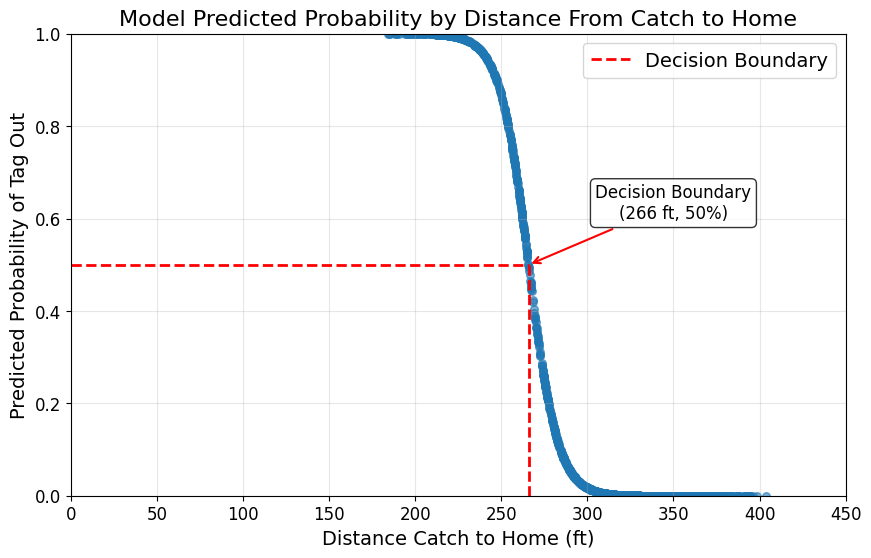

In [50]:
distance_catch_to_home_pd = X_test["distance_catch_to_home"]
plt.figure(figsize=(10, 6))
plt.scatter(distance_catch_to_home_pd, y_pred_proba, alpha=0.6, s=30)

# Create decision boundary lines that only extend to the intersection point
# Vertical line from bottom to y=0.5
plt.plot([266, 266], [0, 0.5], color='red', linestyle='--', linewidth=2, label='Decision Boundary')
# Horizontal line from left edge to x=266
plt.plot([0, 266], [0.5, 0.5], color='red', linestyle='--', linewidth=2)

# Add annotation with arrow pointing to the intersection
plt.annotate('Decision Boundary\n(266 ft, 50%)', 
             xy=(266, 0.5),  # Point to annotate (intersection)
             xytext=(350, 0.6),  # Text position (offset to the right and up)
             arrowprops=dict(arrowstyle='->', 
                           color='red', 
                           lw=1.5),
             fontsize=12,  # Consistent with labels
             ha='center',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.xlabel('Distance Catch to Home (ft)', fontsize=14)
plt.ylabel('Predicted Probability of Tag Out', fontsize=14)
plt.title('Model Predicted Probability by Distance From Catch to Home', fontsize=16)
plt.xlim([0, 450])
plt.ylim([0, 1])
plt.legend(fontsize=14)
plt.grid(True, alpha=0.3)

# Make tick labels consistent too
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

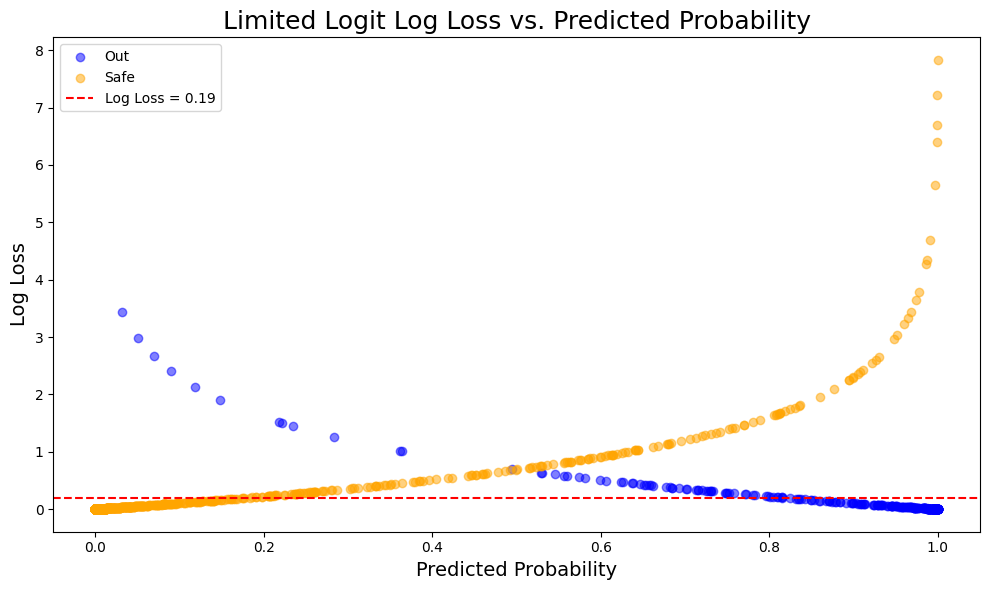

In [57]:
y_true = results['y_test']
y_pred_proba = results['y_pred_proba']

eps = 1e-15  # to avoid log(0)
y_pred_proba_clipped = np.clip(y_pred_proba, eps, 1 - eps)
log_loss_per_sample = -(
    y_true * np.log(y_pred_proba_clipped) +
    (1 - y_true) * np.log(1 - y_pred_proba_clipped)
)

mask_1 = y_true == 1
mask_0 = y_true == 0

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_proba[mask_1], log_loss_per_sample[mask_1], 
            color='blue', alpha=0.5, label='Out')
plt.scatter(y_pred_proba[mask_0], log_loss_per_sample[mask_0], 
            color='orange', alpha=0.5, label='Safe')

plt.axhline(0.19, color='red', linestyle='--', label='Log Loss = 0.19')

plt.xlabel('Predicted Probability', fontsize=14)
plt.ylabel('Log Loss', fontsize=14)
plt.title('Limited Logit Log Loss vs. Predicted Probability', fontsize=18)
plt.legend()
plt.tight_layout()
plt.show()

#### Random Forest - Limited Predictors and Tag Out Censoring

In [51]:
# Prepare GridSearch
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="RandomForestClassifier",
    oversampling_method="SMOTE",
    param_grid=rf_param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Censored Train and Censored Test
results = model_prep_on_base(
    on_base_lf = logit_set_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = True,
    test_stay_to_out = False,
    test_stay_to_out_threshold = True,
)

Total features: 2
Total Predictors: 1
Total Responses: 1
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters: 
classifier__max_depth = 20
classifier__max_features = sqrt
classifier__min_samples_leaf = 4
classifier__min_samples_split = 10
classifier__n_estimators = 500
classifier__random_state = 42

Best cross-validation score: -0.0635

              precision    recall  f1-score   support

       False       0.98      0.92      0.95      1161
        True       0.75      0.92      0.83       285

    accuracy                           0.92      1446
   macro avg       0.86      0.92      0.89      1446
weighted avg       0.93      0.92      0.93      1446

Brier Score: 0.0639
log loss: 0.5248

Predictors:
distance_catch_to_home

Response:
is_out


#### XGBoost - Limited Predictors and Tag Out Censoring

In [52]:
# Prepare GridSearch
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="GradientBoostingClassifier",
    oversampling_method="SMOTE",
    param_grid=xg_param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Censored Train and Censored Test
results = model_prep_on_base(
    on_base_lf = logit_set_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = True,
    test_stay_to_out = False,
    test_stay_to_out_threshold = True,
)

Total features: 2
Total Predictors: 1
Total Responses: 1
Fitting 5 folds for each of 64 candidates, totalling 320 fits

Best parameters: 
classifier__learning_rate = 0.01
classifier__max_depth = 3
classifier__max_features = sqrt
classifier__min_samples_split = 10
classifier__n_estimators = 500
classifier__random_state = 42
classifier__subsample = 0.8

Best cross-validation score: -0.0582

              precision    recall  f1-score   support

       False       0.99      0.92      0.95      1161
        True       0.74      0.95      0.83       285

    accuracy                           0.92      1446
   macro avg       0.86      0.93      0.89      1446
weighted avg       0.94      0.92      0.93      1446

Brier Score: 0.0576
log loss: 0.1914

Predictors:
distance_catch_to_home

Response:
is_out


#### MLP - Limited Predictors and Tag Out Censoring

In [53]:
# Prepare GridSearch
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="MLPClassifier",
    oversampling_method="SMOTE",
    param_grid=mlp_param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Censored Train and Censored Test
results = model_prep_on_base(
    on_base_lf = logit_set_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = True,
    test_stay_to_out = False,
    test_stay_to_out_threshold = True,
)

Total features: 2
Total Predictors: 1
Total Responses: 1
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/taylorswrite/git/Sacrifice-Fly-Modeling/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/taylorswrite/git/Sacrifice-Fly-Modeling/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/taylorswrite/git/Sacrifice-Fly-Modeling/.venv/lib/python3.11/site-packages/sklearn/neural_netw


Best parameters: 
classifier__activation = relu
classifier__alpha = 0.01
classifier__hidden_layer_sizes = (50,)
classifier__max_iter = 500
classifier__random_state = 42
classifier__solver = lbfgs

Best cross-validation score: -0.0585

              precision    recall  f1-score   support

       False       0.99      0.91      0.95      1161
        True       0.73      0.95      0.83       285

    accuracy                           0.92      1446
   macro avg       0.86      0.93      0.89      1446
weighted avg       0.94      0.92      0.93      1446

Brier Score: 0.0577
log loss: 0.1897

Predictors:
distance_catch_to_home

Response:
is_out


/home/taylorswrite/git/Sacrifice-Fly-Modeling/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
